In [ ]:
import os
import specdal as sd
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

In [139]:
# read spectrum files in directory
datadir = r'C:\Users\xfour\Downloads\drive-download-20241205T210751Z-001\ReflectanceTVC\20230807'
c = sd.Collection(name='GreenByte', directory=datadir)

In [140]:
# Parameter setup
svc_name = 'svc2042'

# Path to the wavelength file
wave_ln = r'C:\Users\xfour\Documents\wave_length_res.csv'

In [141]:
# See the names of spectra files
spec_name = pd.DataFrame(os.listdir(datadir))
spec_name.columns = ['Spectral_name']
print("Number of Spectra:", len(spec_name))
print(spec_name)

Number of Spectra: 273
        Spectral_name
0      2-B007_001.sig
1      2-B007_002.sig
2      2-B007_003.sig
3      2-B007_004.sig
4      2-B008_001.sig
..                ...
268  P12-C004_003.sig
269        wr_001.sig
270        wr_002.sig
271        wr_003.sig
272        wr_004.sig

[273 rows x 1 columns]


# Grouping
Collection class provides a groupby function. This function iterates through the names of the spectra and forms groups in the following way:

1. split the name into fields using the separator character.
2. combine indicated fields to define a group.

For example, if a spectrum has name 'A-B-C-D-100', separator is '-', and indices are [0, 3, 4], then

1. the name is split into fields by '-' => ['A', 'B', 'C', 'D', '100'].
2. the spectrum belongs in the group defined by combining the 0th, 3rd, and 4th elements => 'A-D-100'

The result of the groupby function is an OrderedDict object. The keys are group names and values are collections containing spectra in the group.

In [142]:
# Define a custom key function with error handling
def separator_keyfun(spectrum, separator, indices, filler="NA"):
    elements = spectrum.name.split(separator)
    # Pad with filler if the number of elements is less than required
    padded_elements = elements + [filler] * (max(indices) + 1 - len(elements))
    # Return the joined string based on the specified indices
    return separator.join([padded_elements[i] for i in indices])

# Use the custom key function in the groupby process
groups = c.groupby(separator='_', indices=[0, 1, 2], filler="NA")

# Extract group names from the keys of the grouped data
group_names = list(groups.keys())

# Convert group names into a DataFrame
group_names_df = pd.DataFrame(group_names, columns=['group_name'])

# Display the DataFrame
print(group_names_df)


       group_name
0      2-B007_001
1      2-B007_002
2      2-B007_003
3      2-B007_004
4      2-B008_001
..            ...
264  P12-C004_003
265        wr_001
266        wr_002
267        wr_003
268        wr_004

[269 rows x 1 columns]


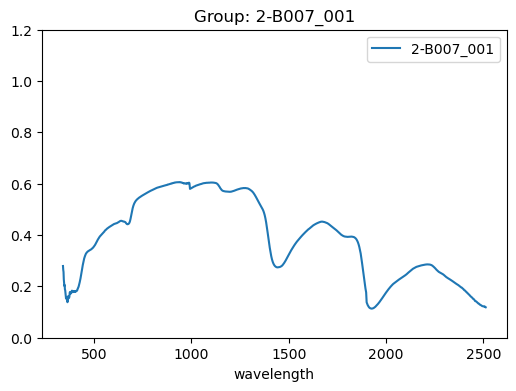

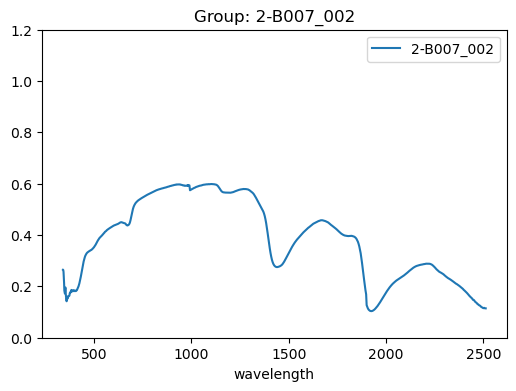

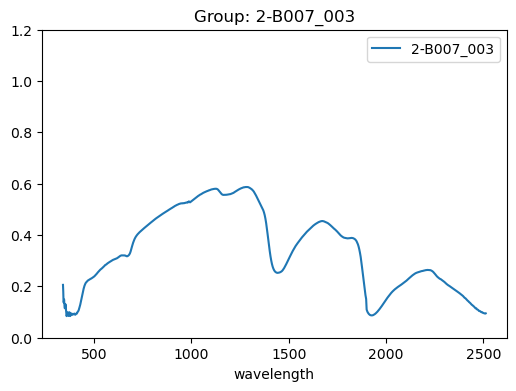

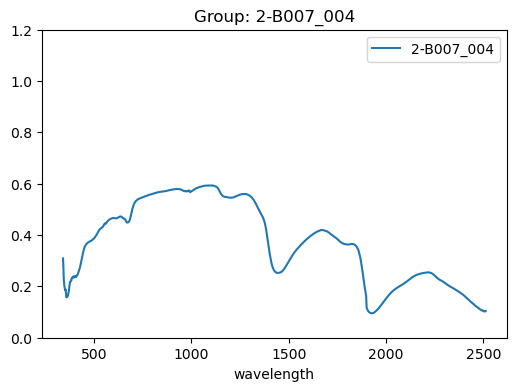

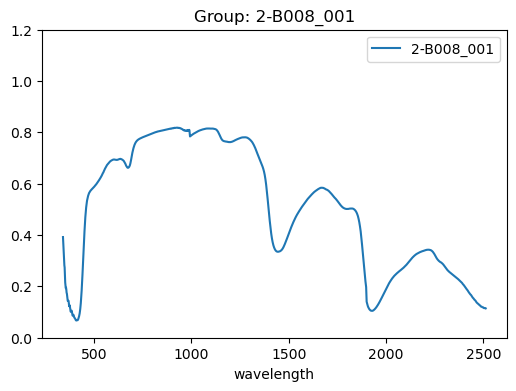

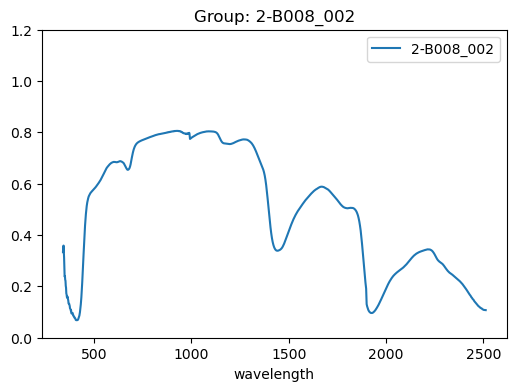

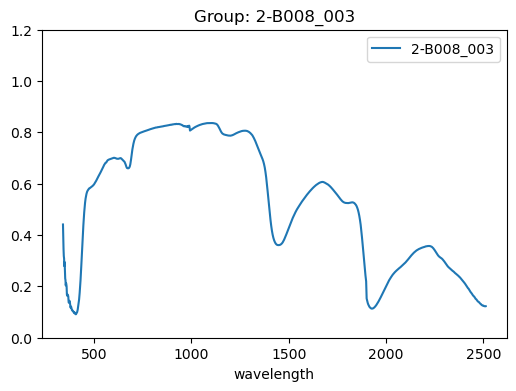

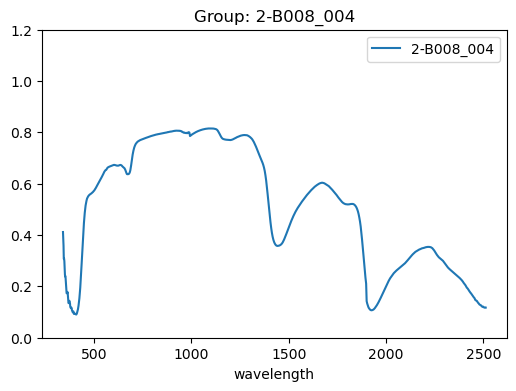

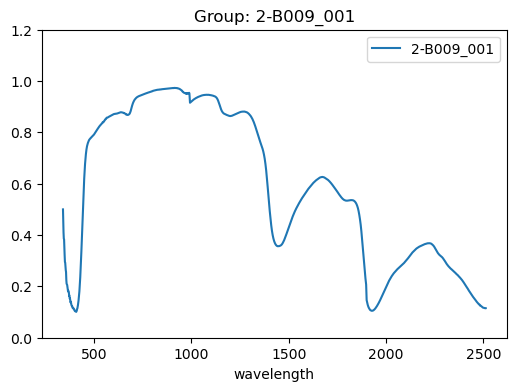

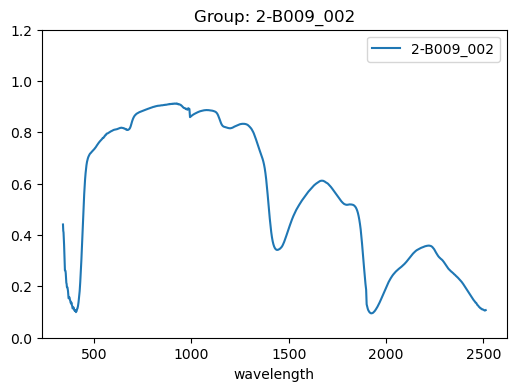

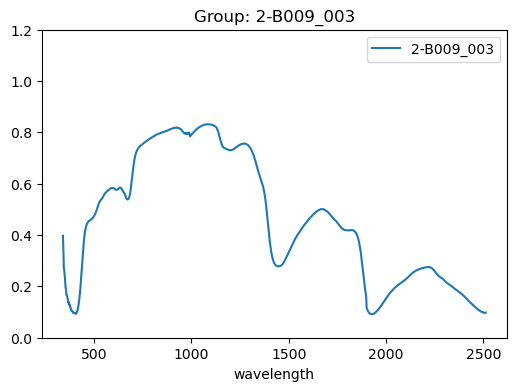

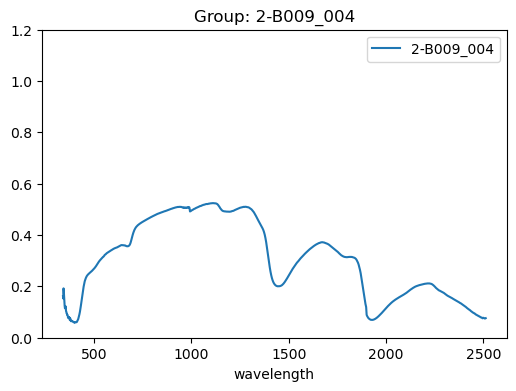

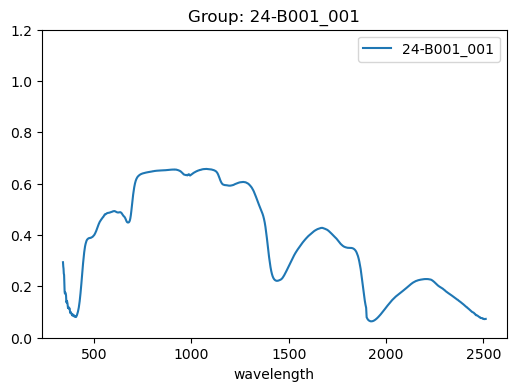

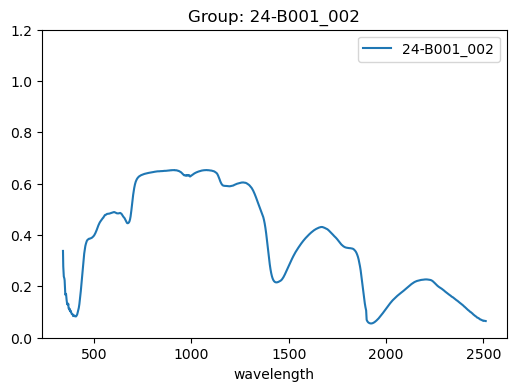

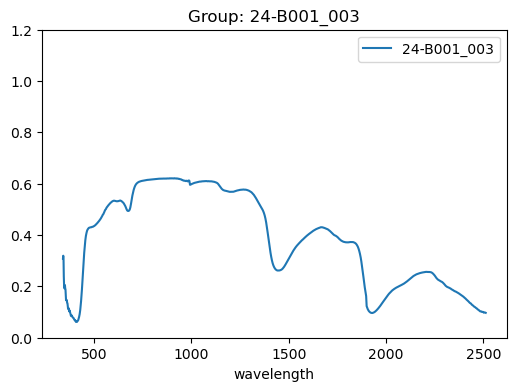

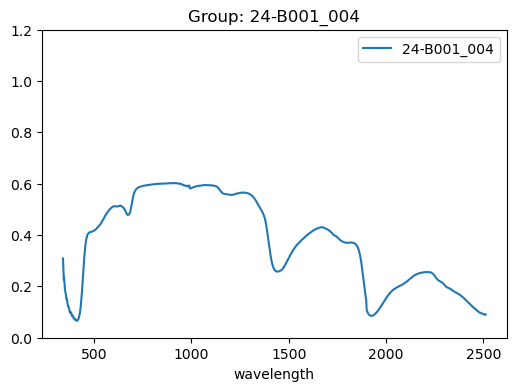

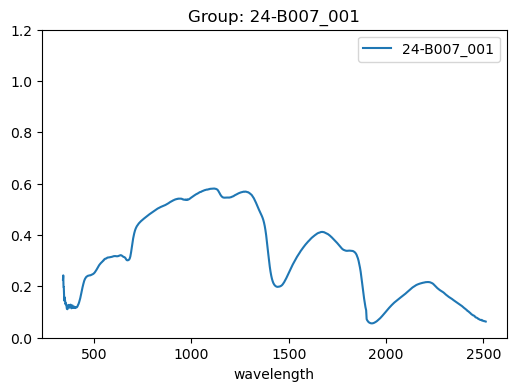

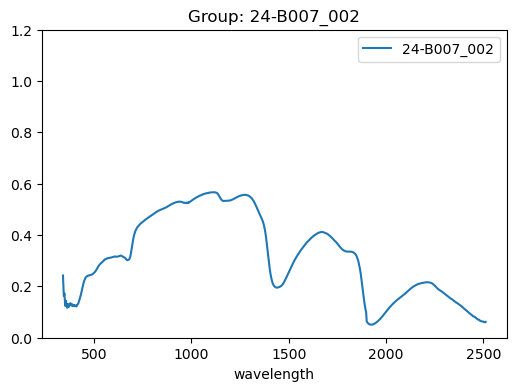

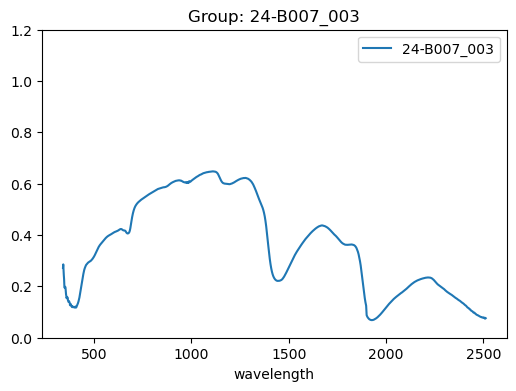

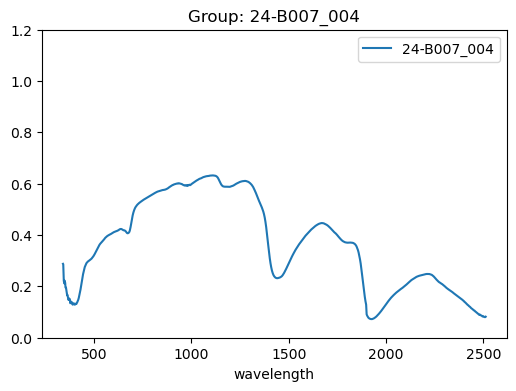

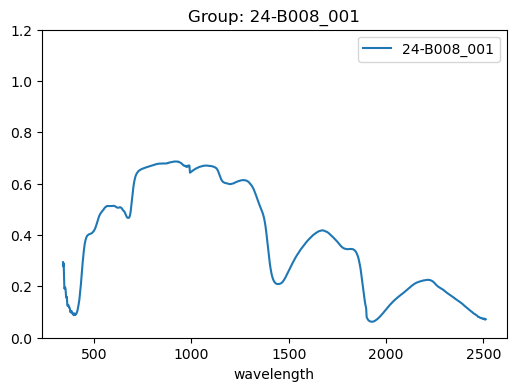

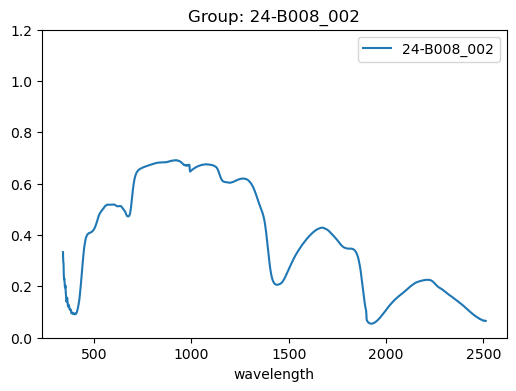

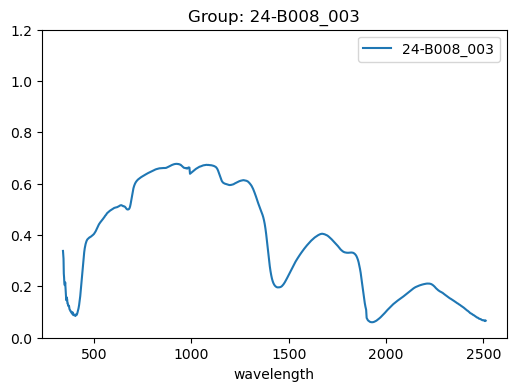

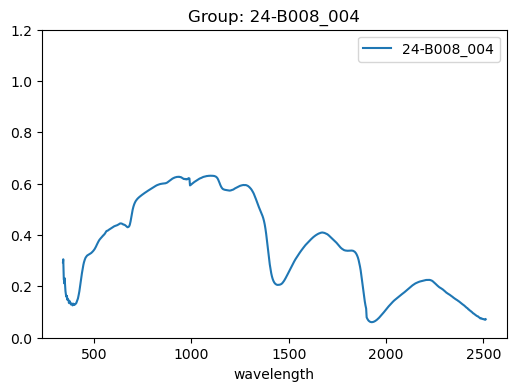

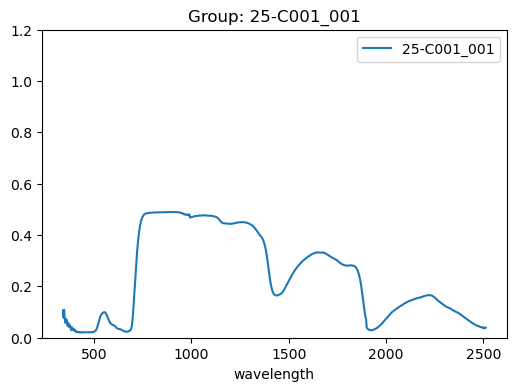

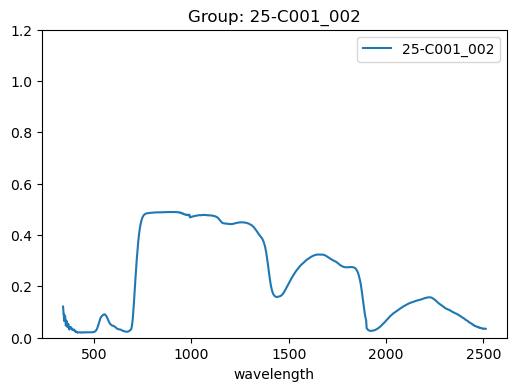

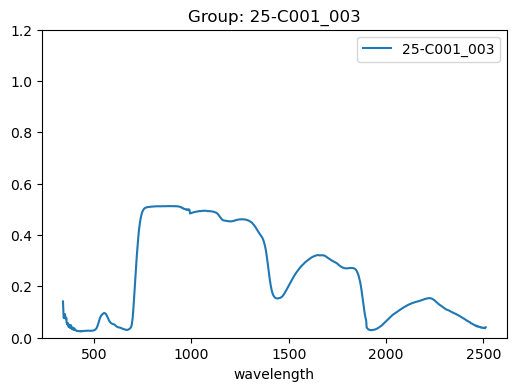

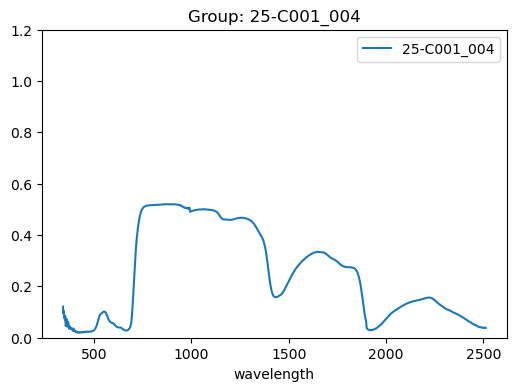

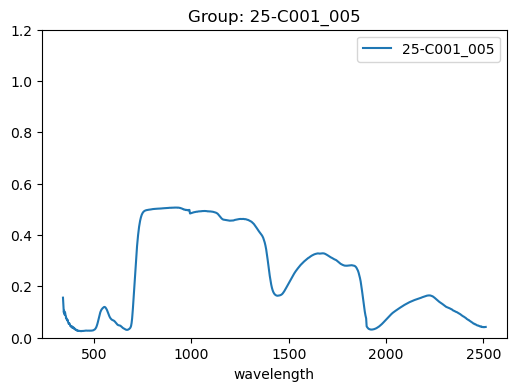

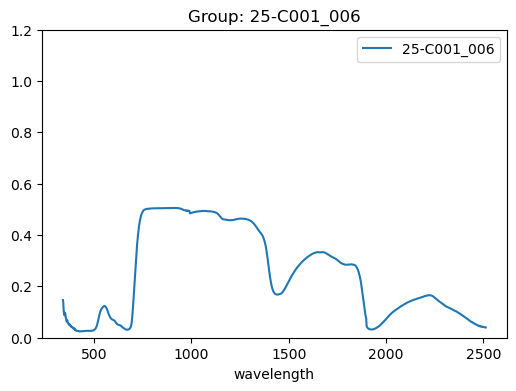

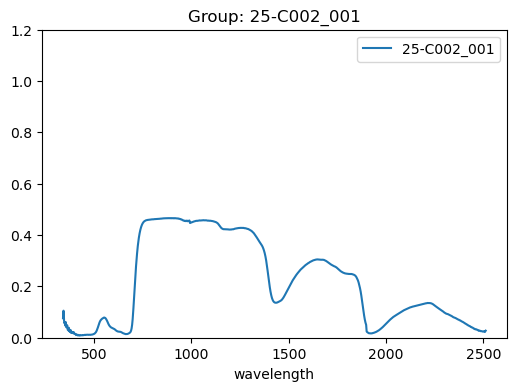

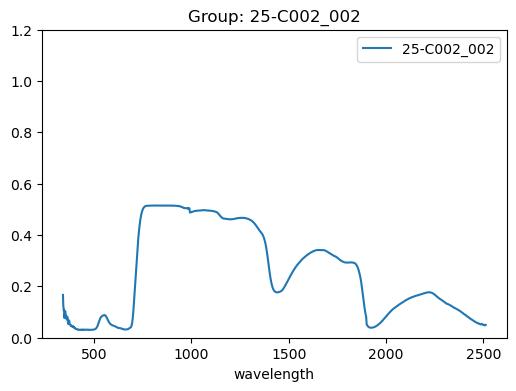

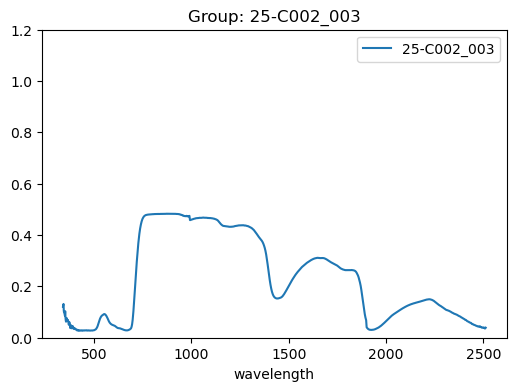

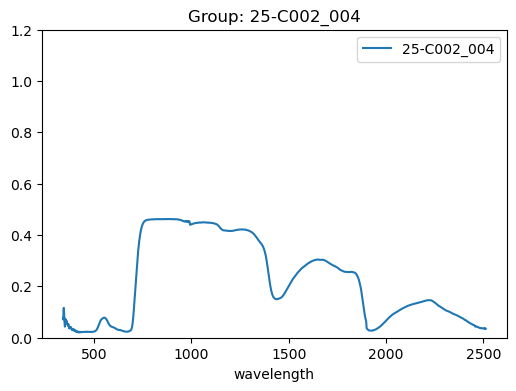

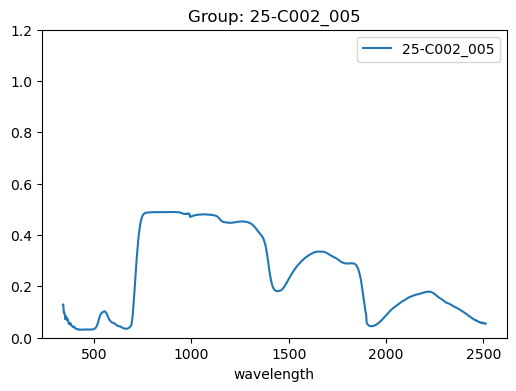

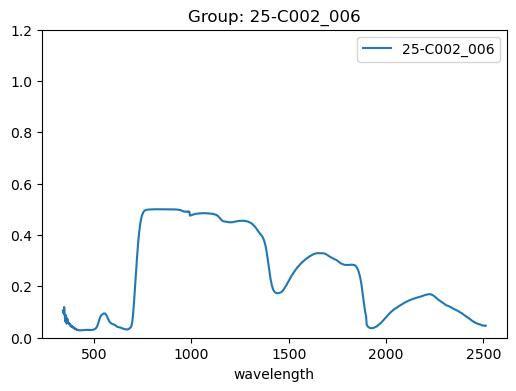

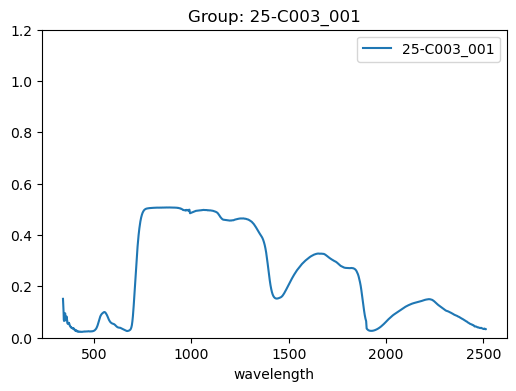

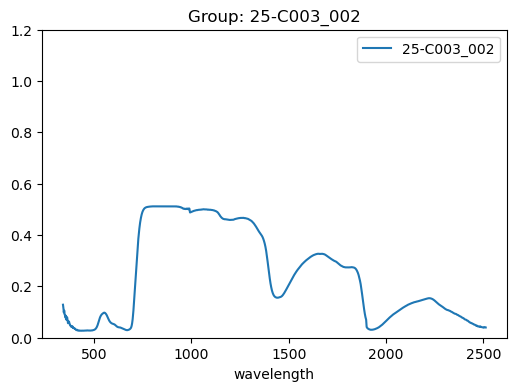

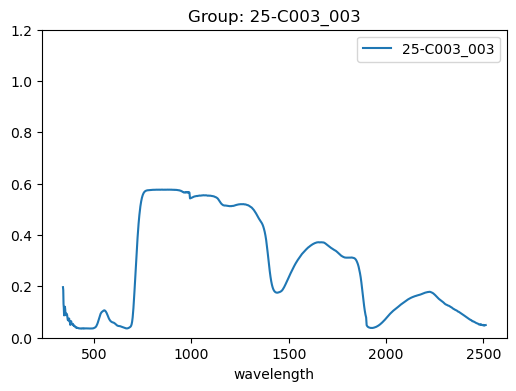

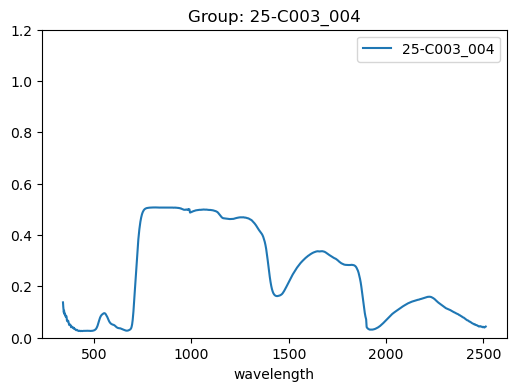

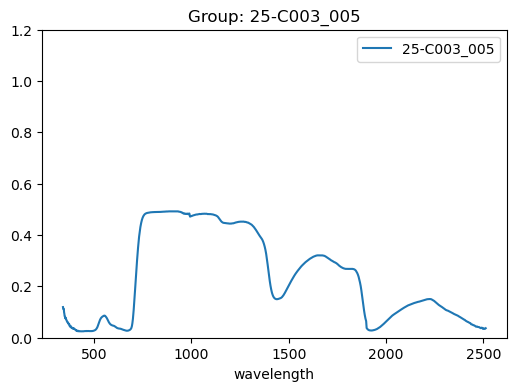

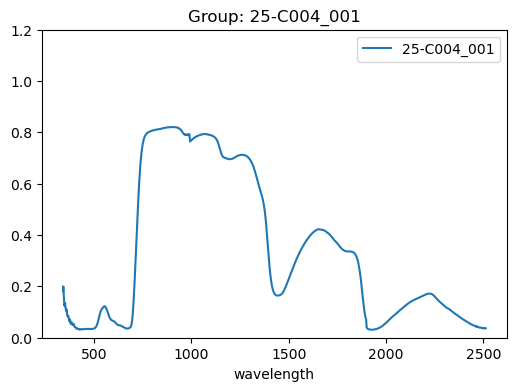

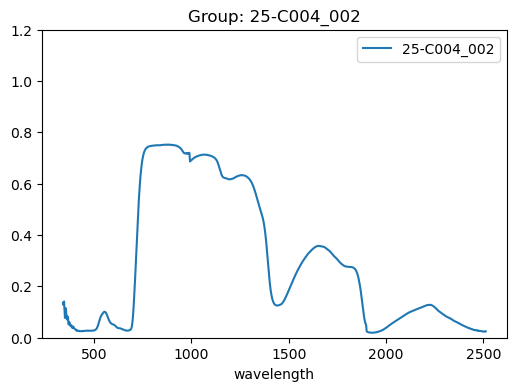

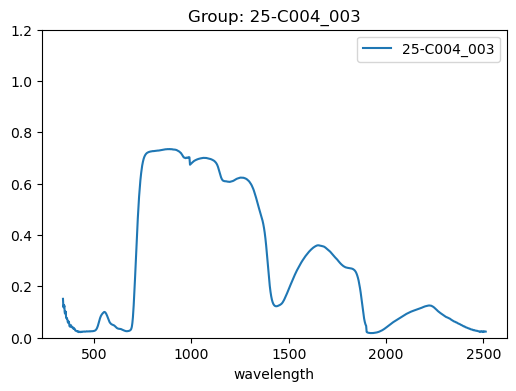

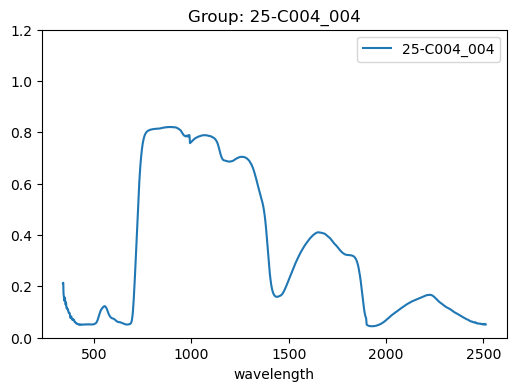

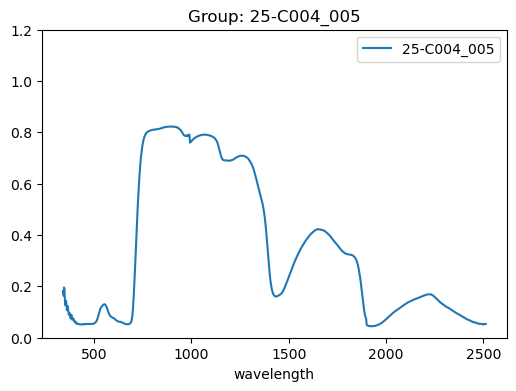

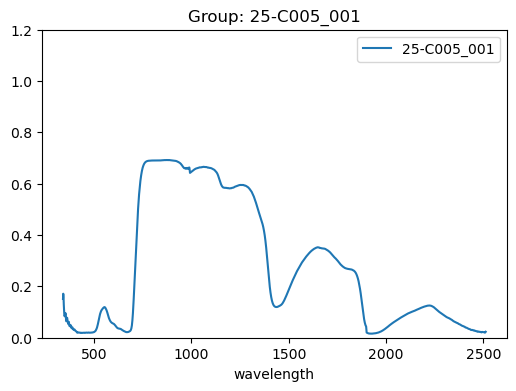

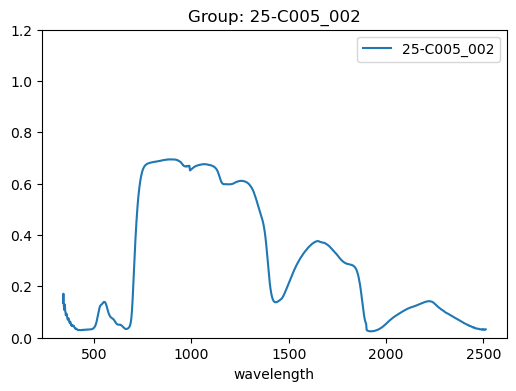

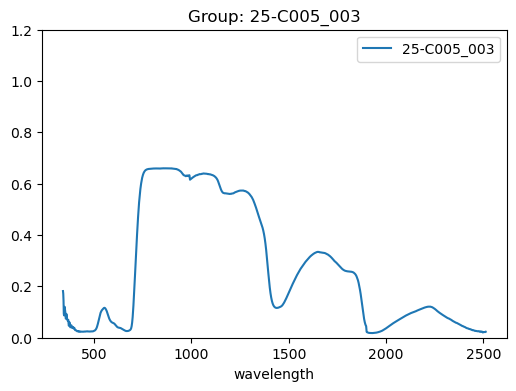

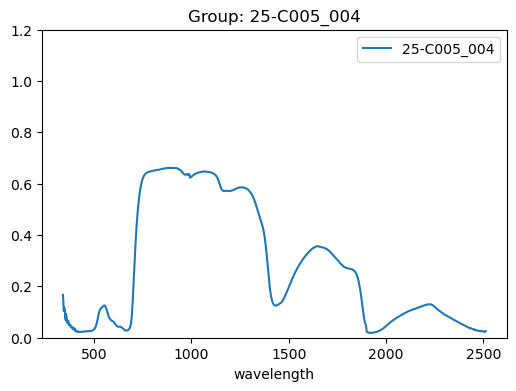

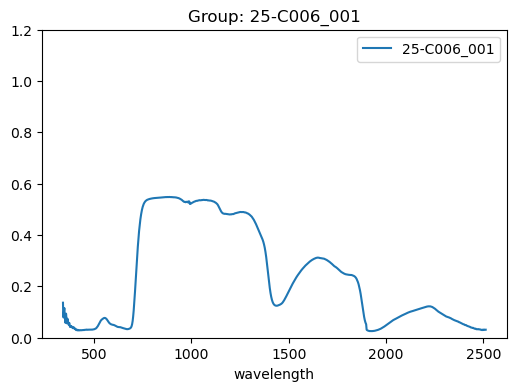

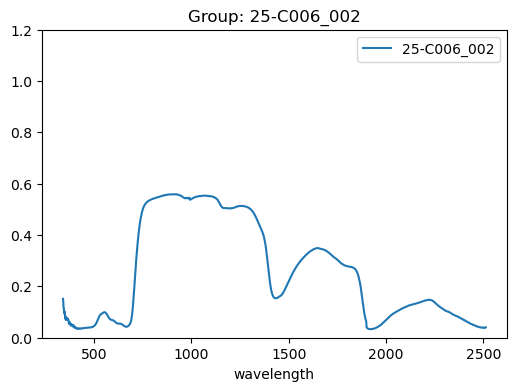

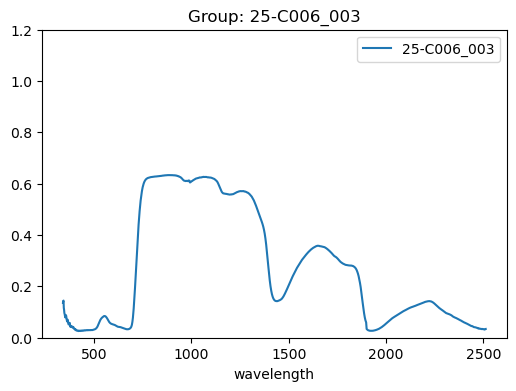

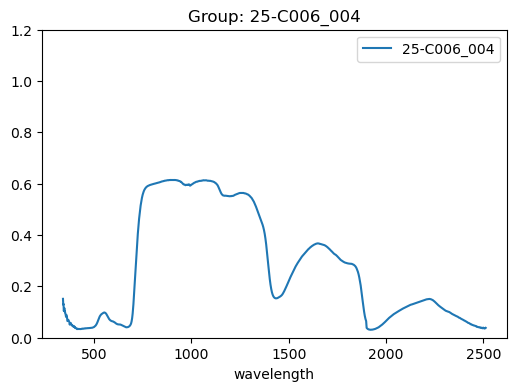

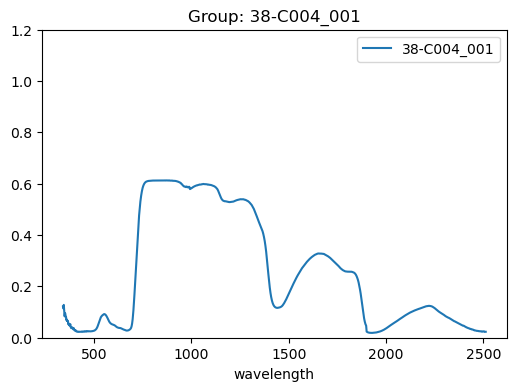

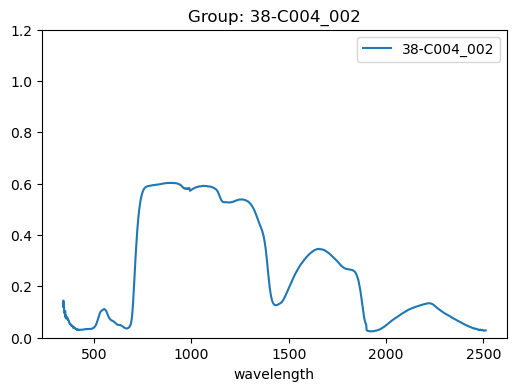

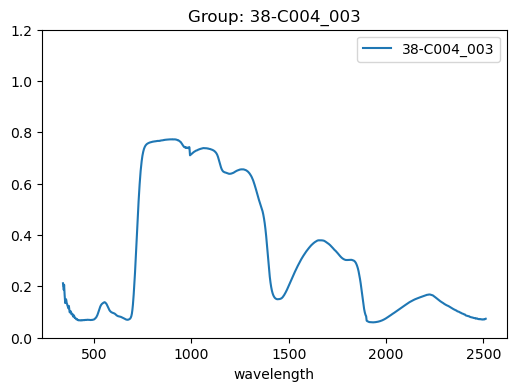

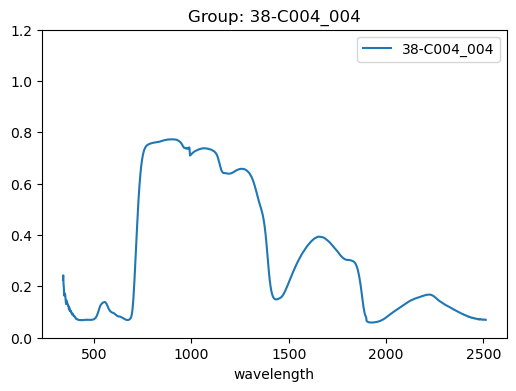

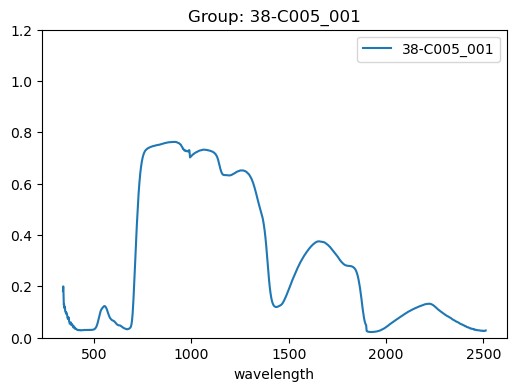

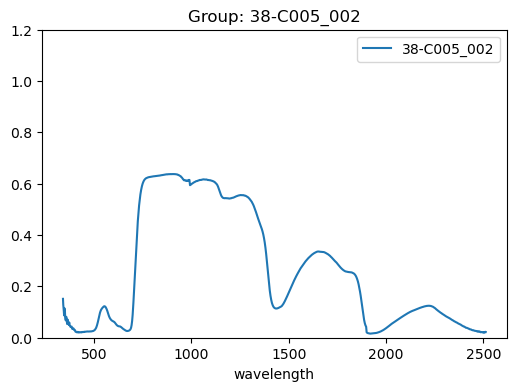

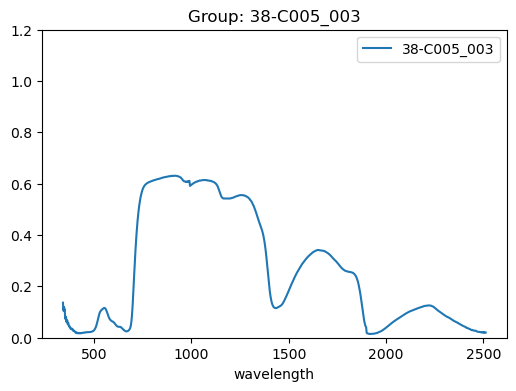

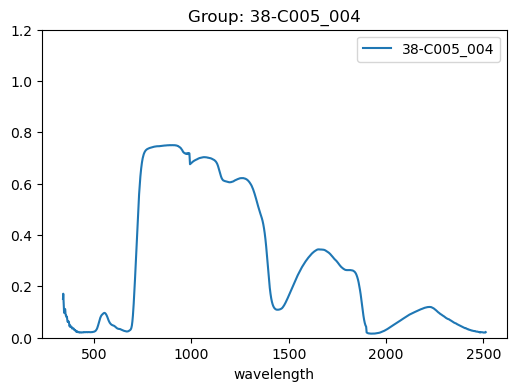

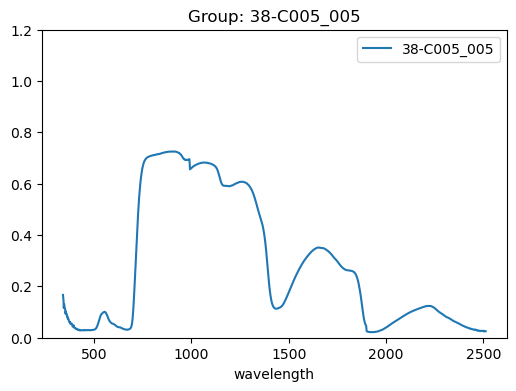

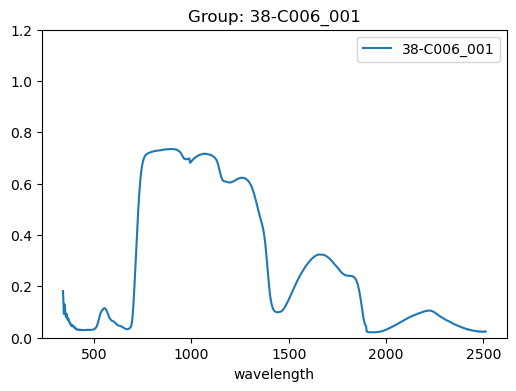

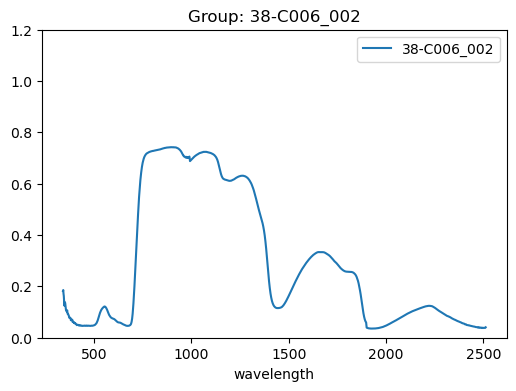

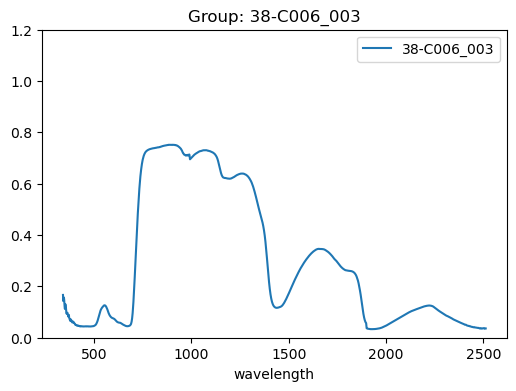

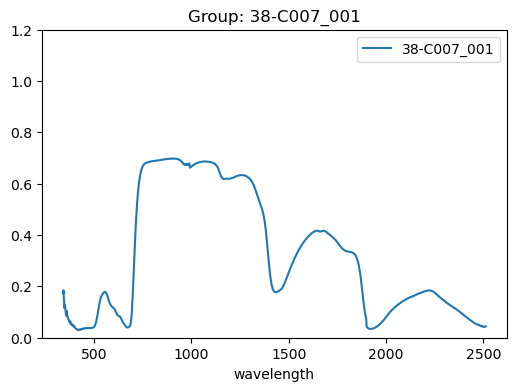

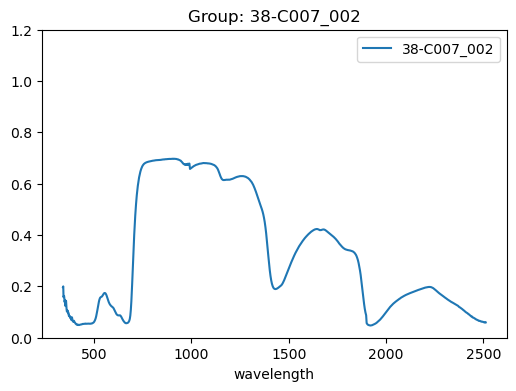

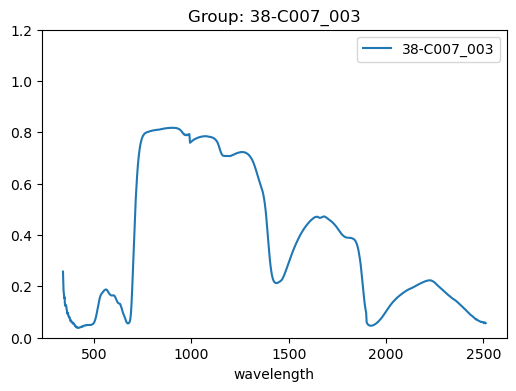

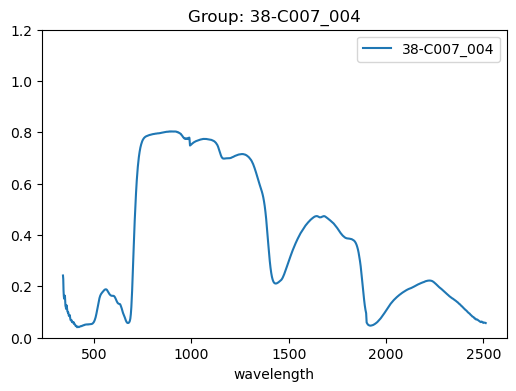

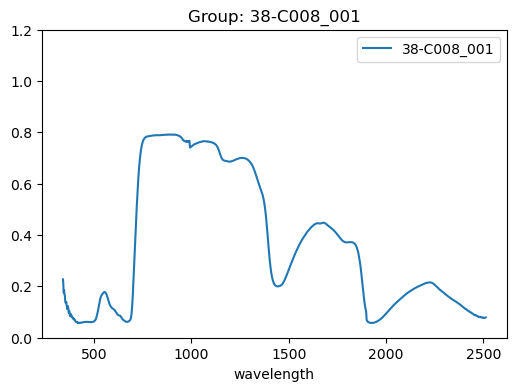

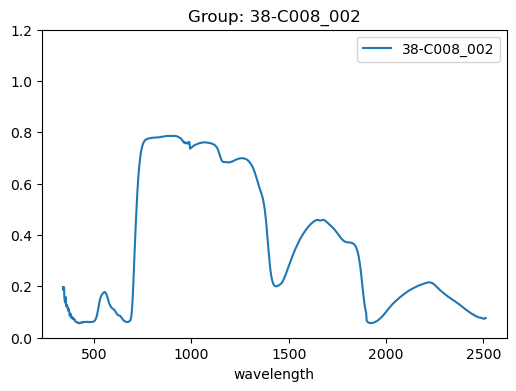

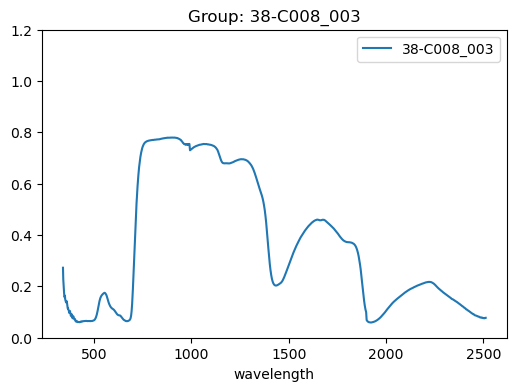

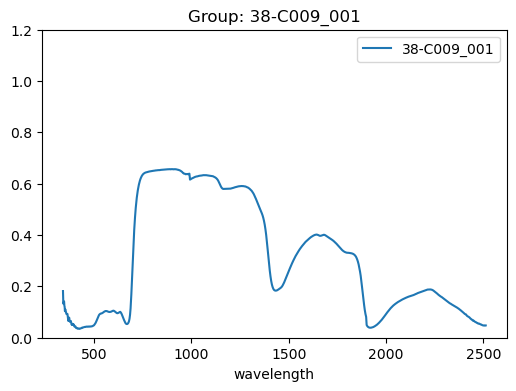

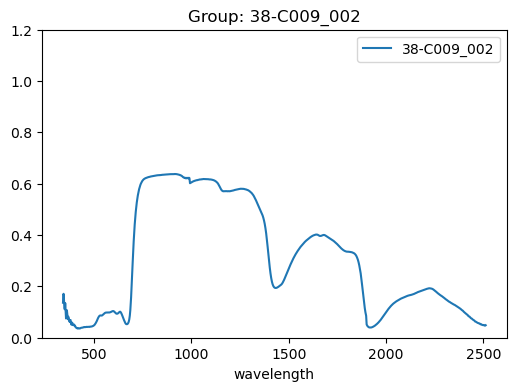

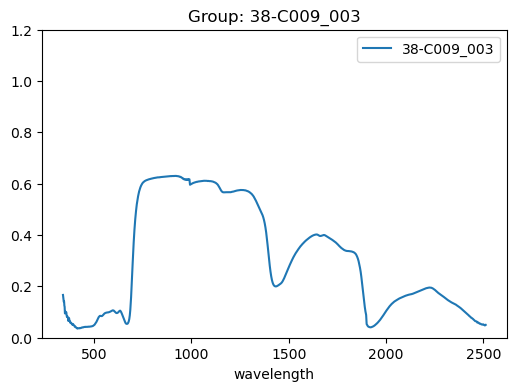

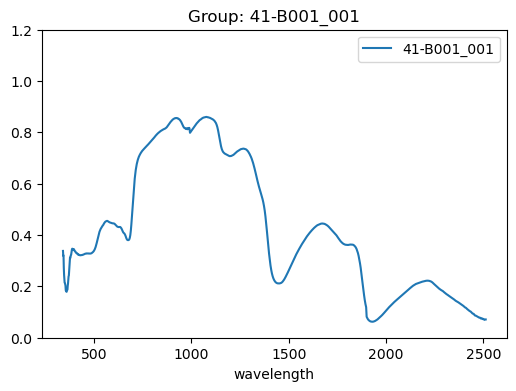

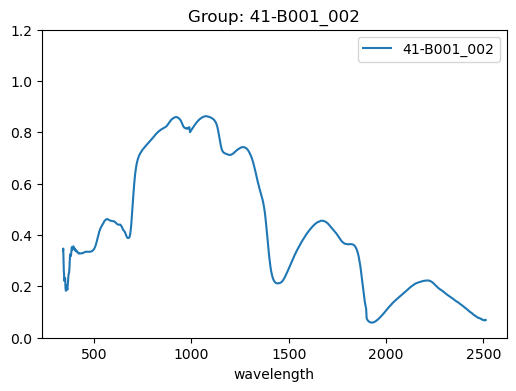

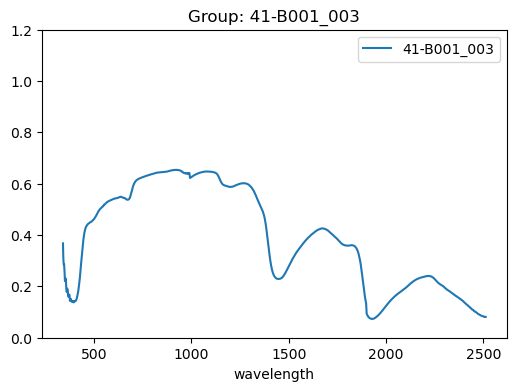

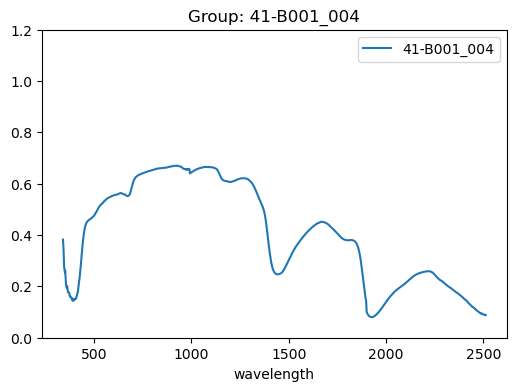

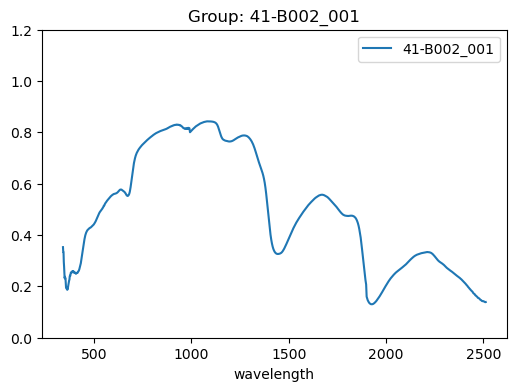

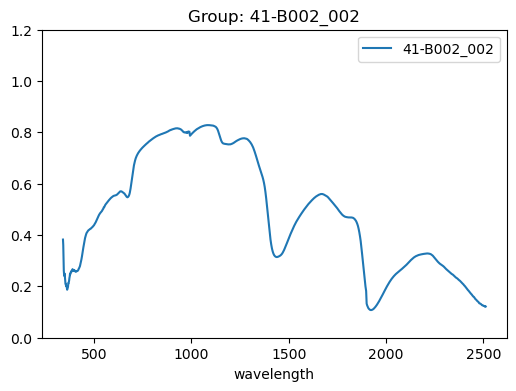

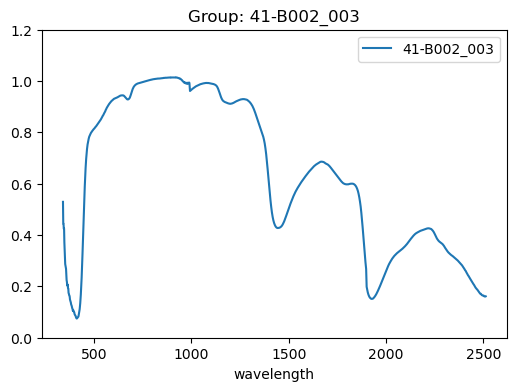

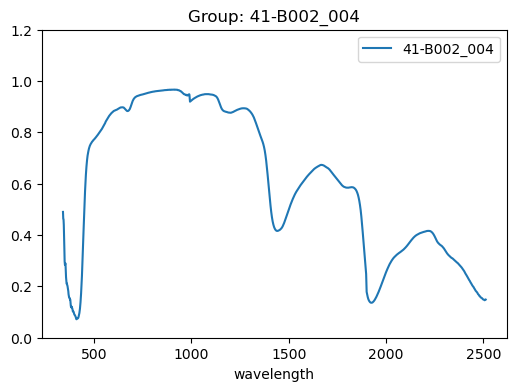

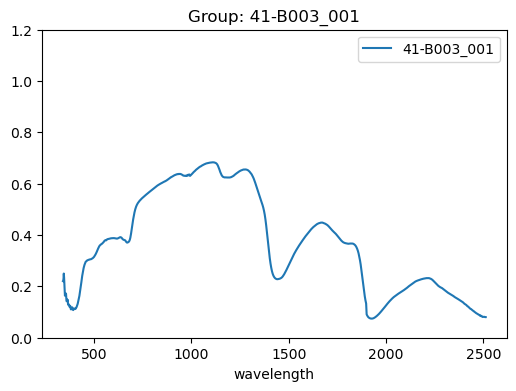

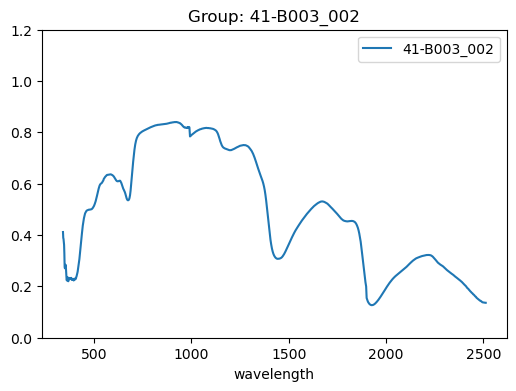

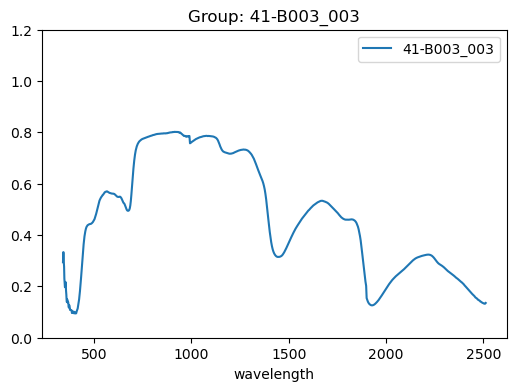

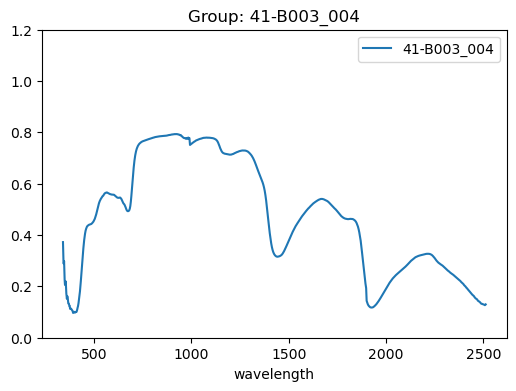

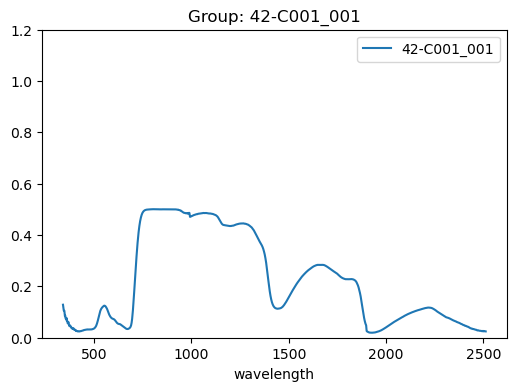

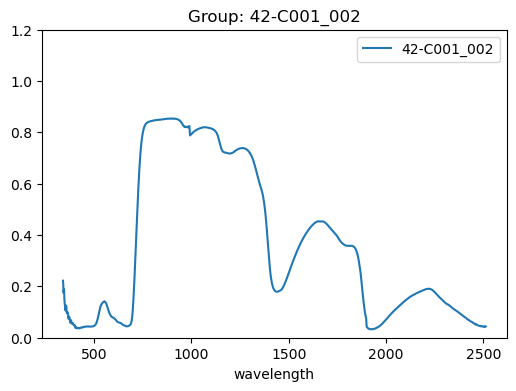

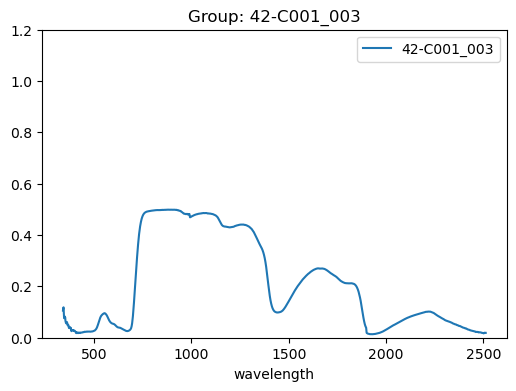

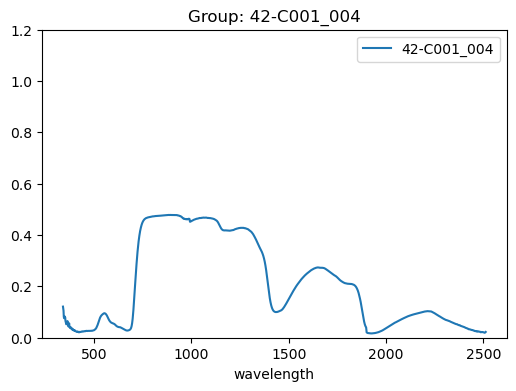

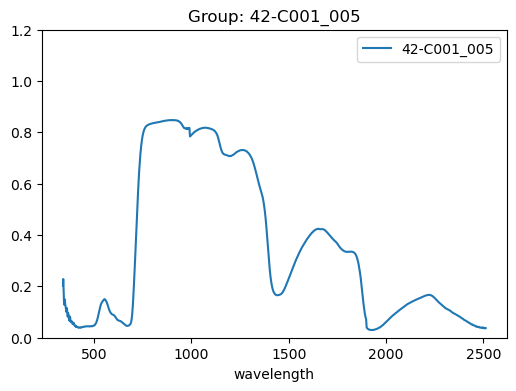

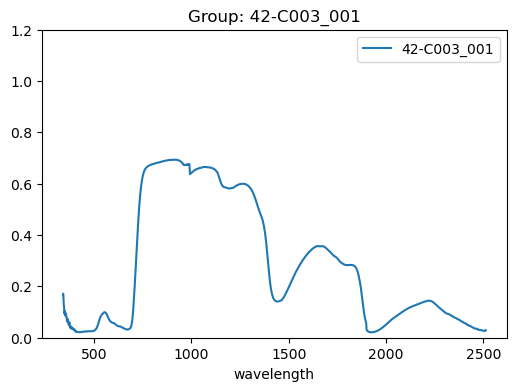

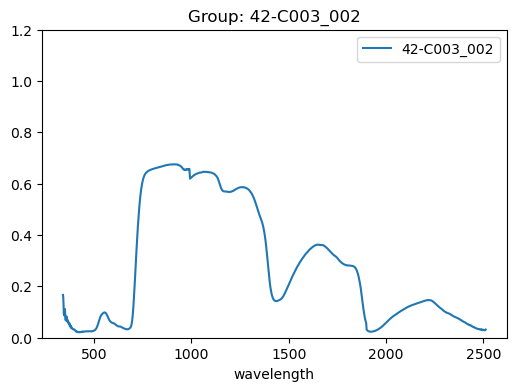

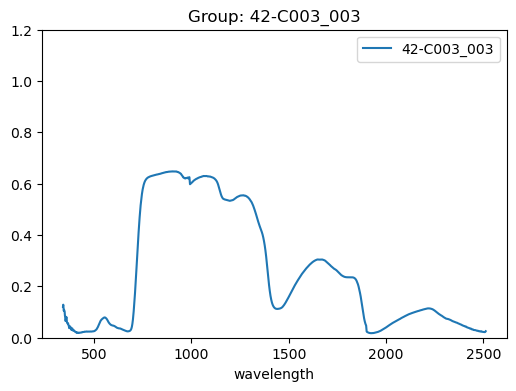

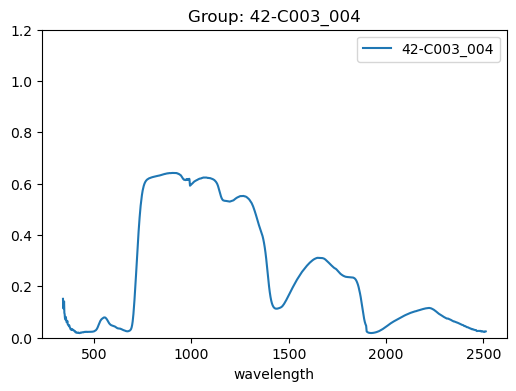

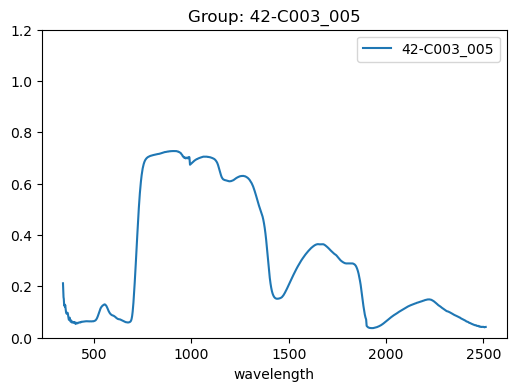

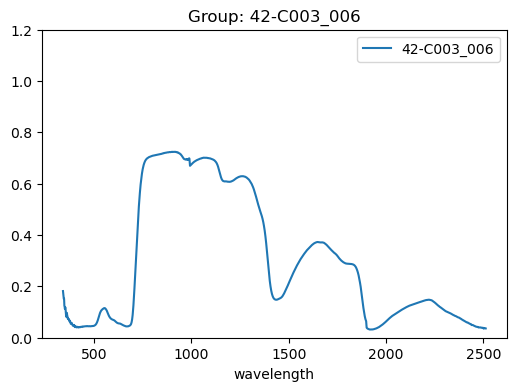

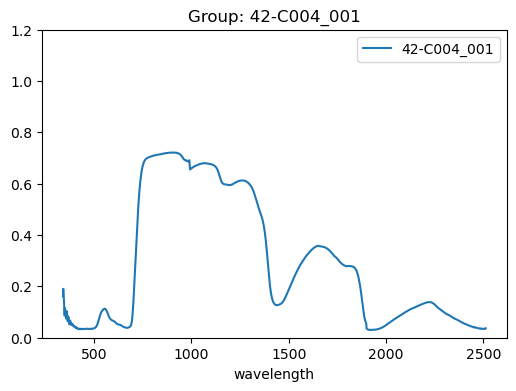

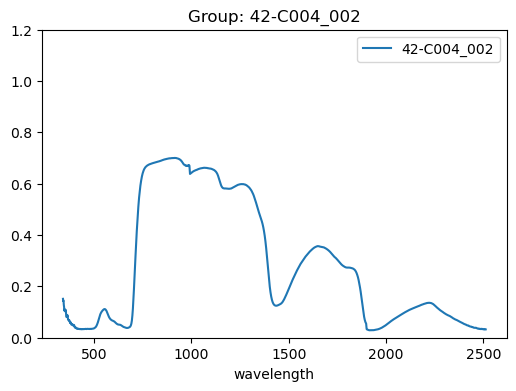

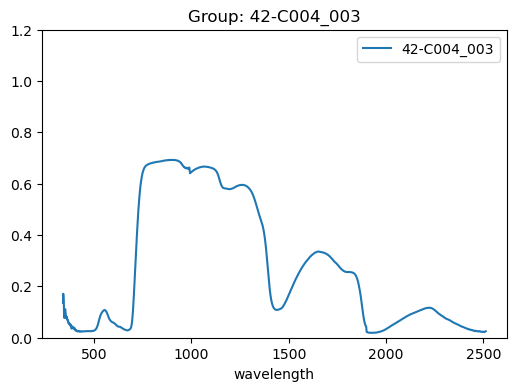

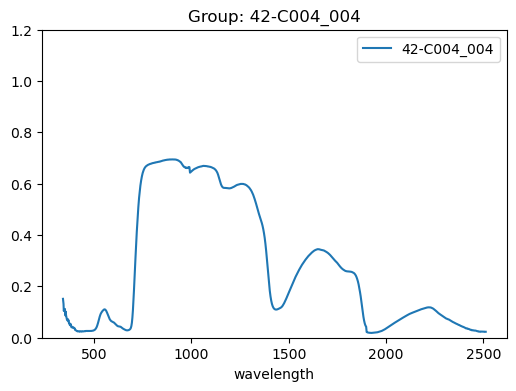

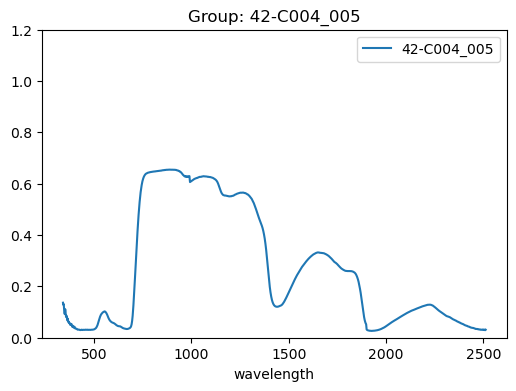

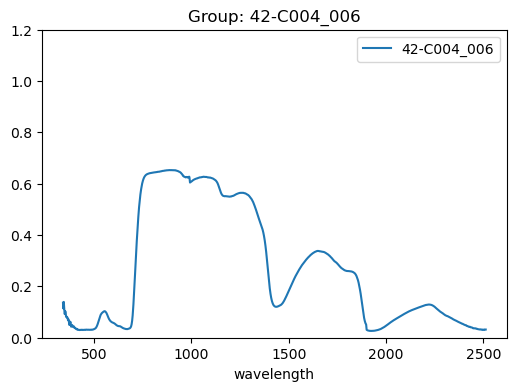

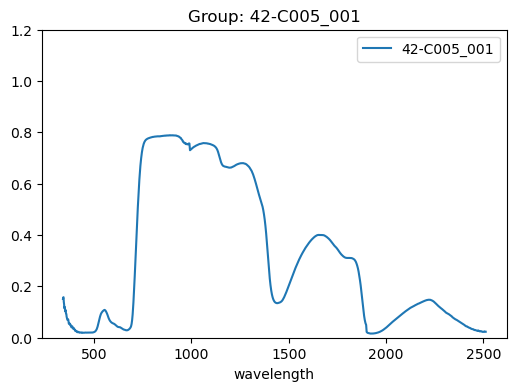

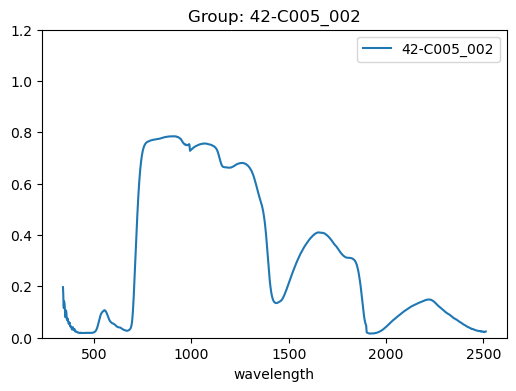

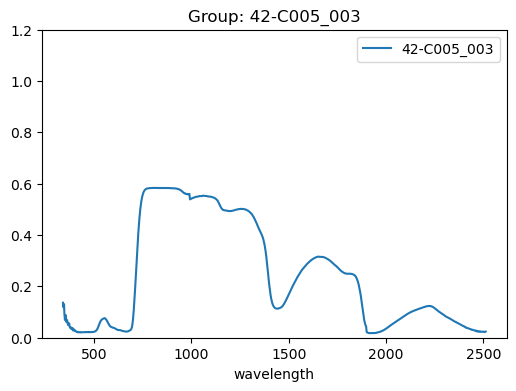

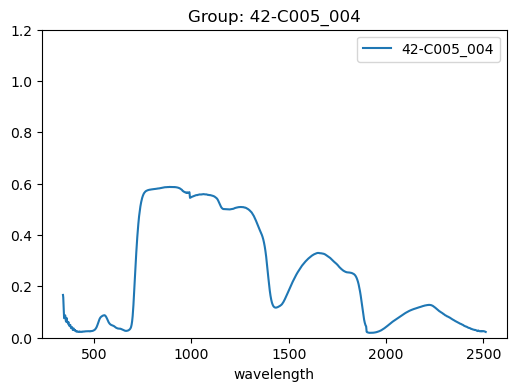

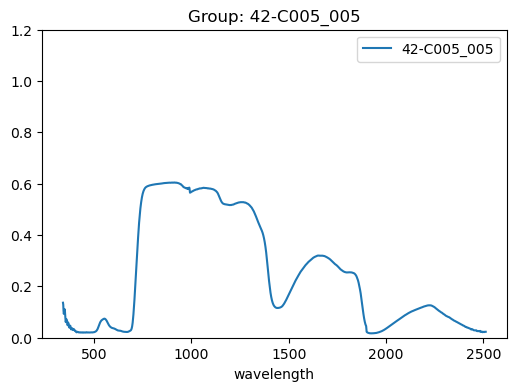

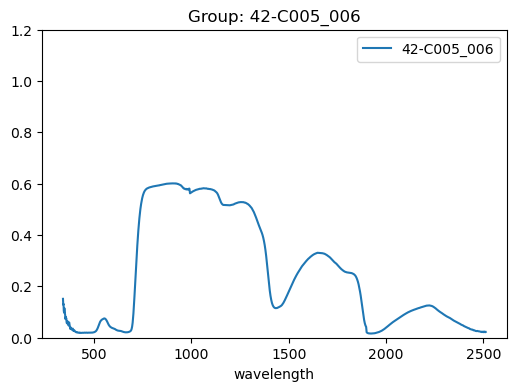

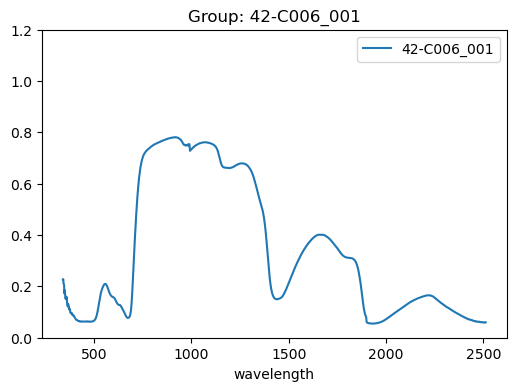

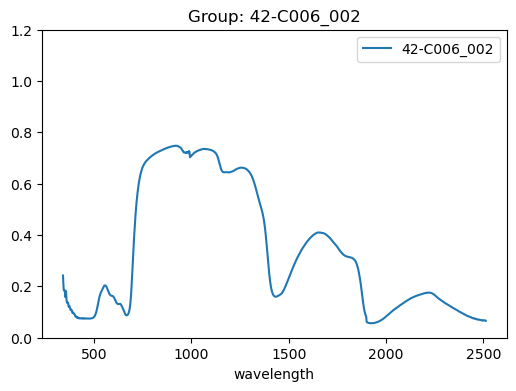

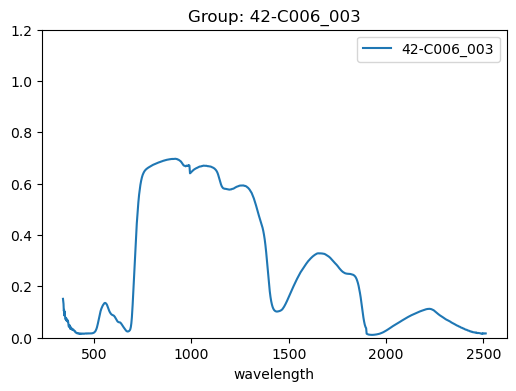

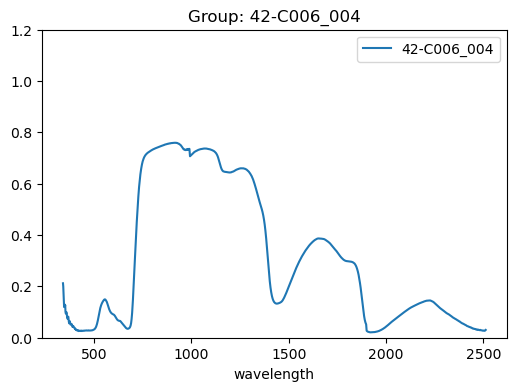

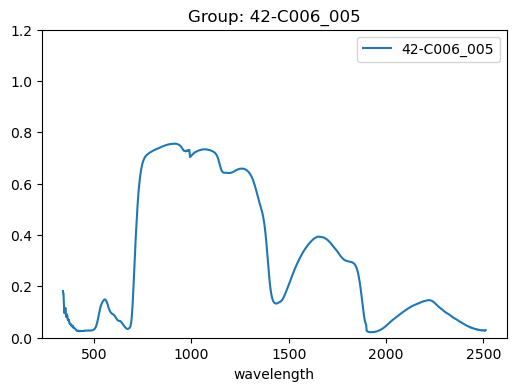

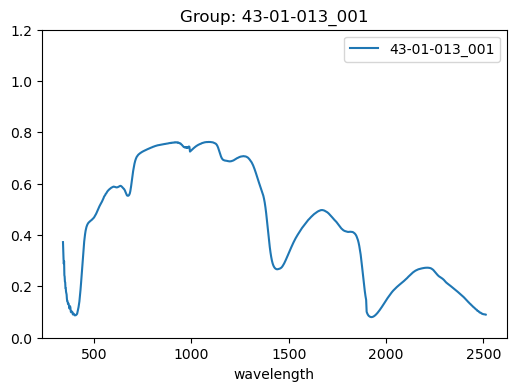

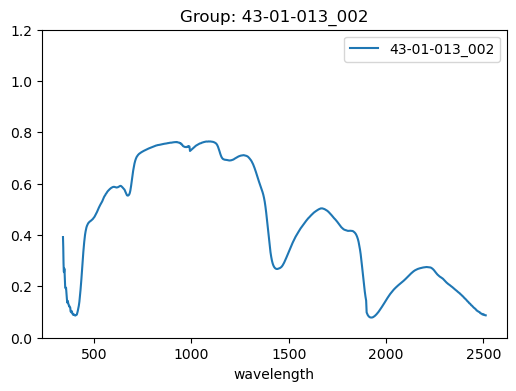

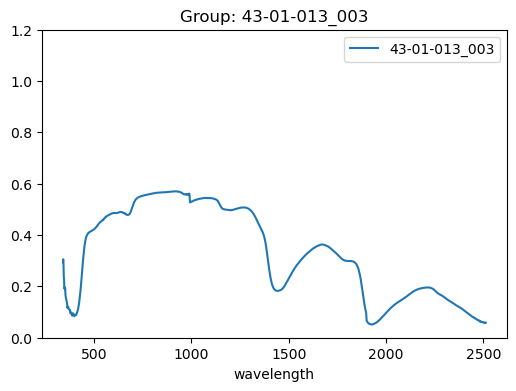

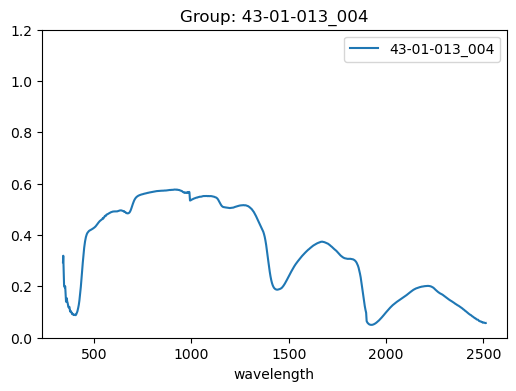

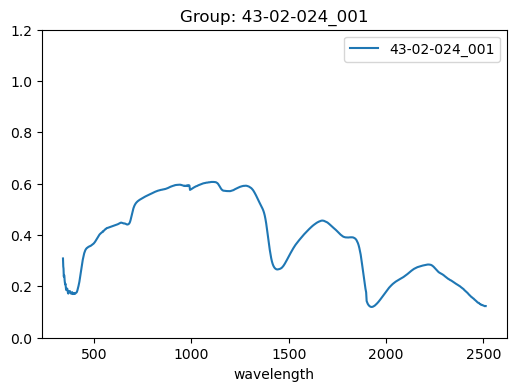

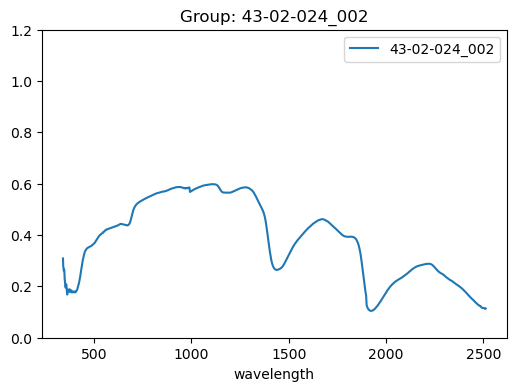

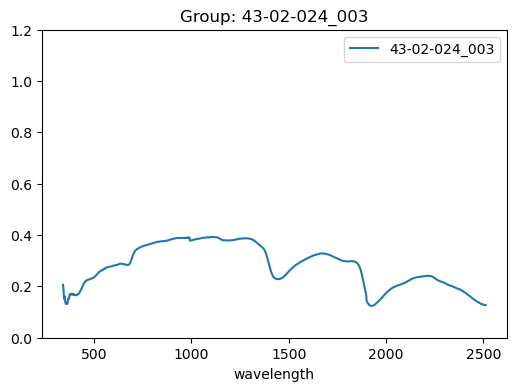

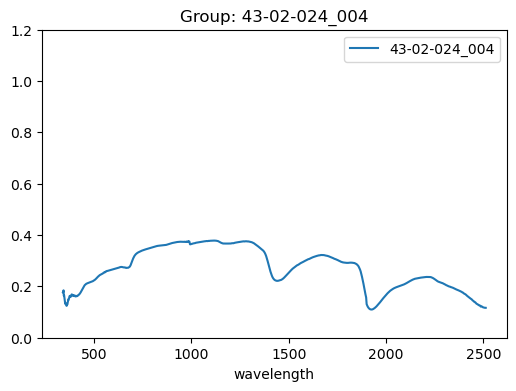

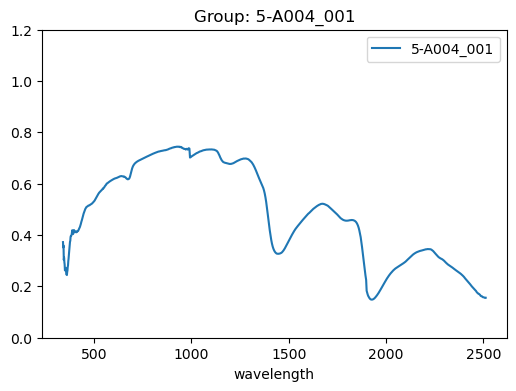

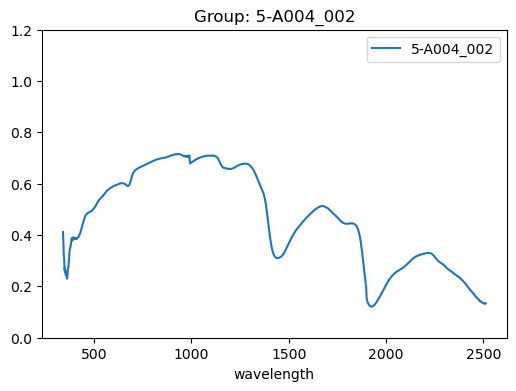

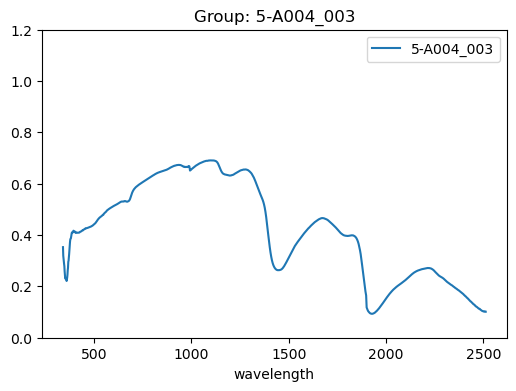

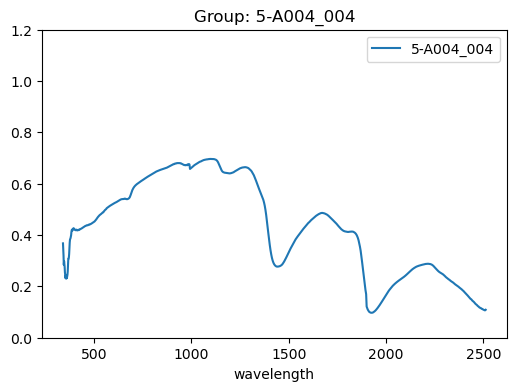

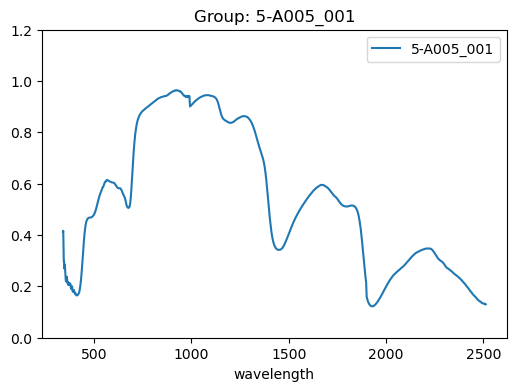

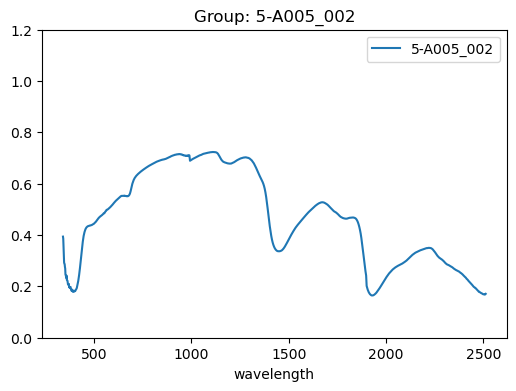

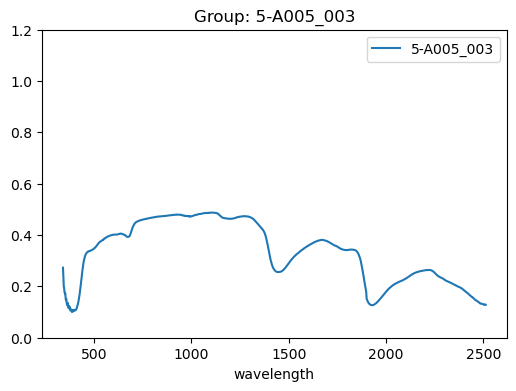

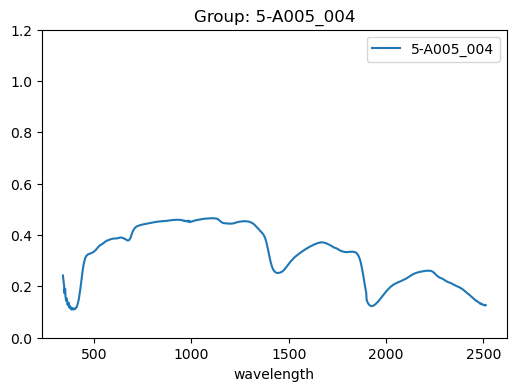

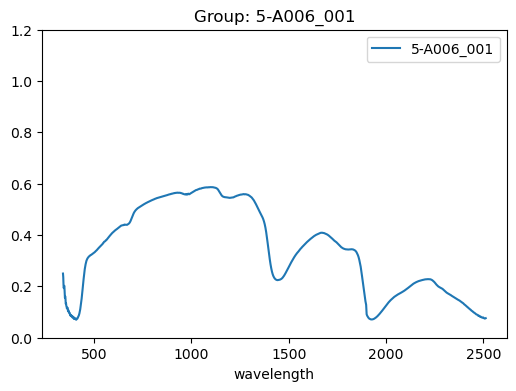

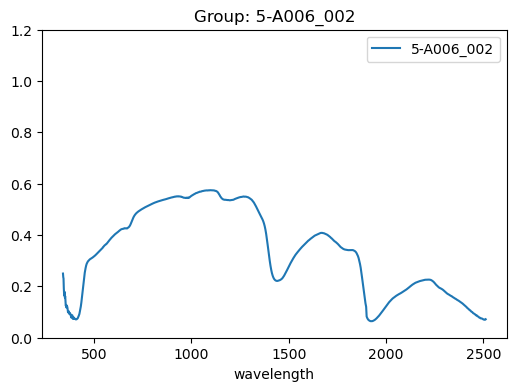

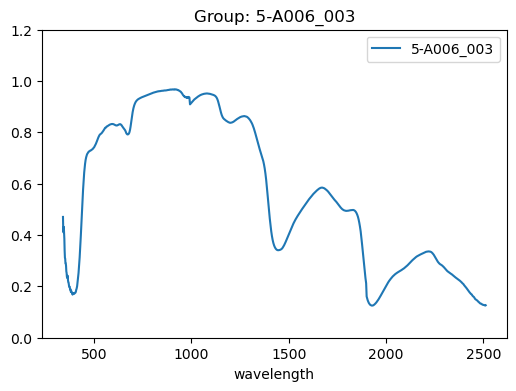

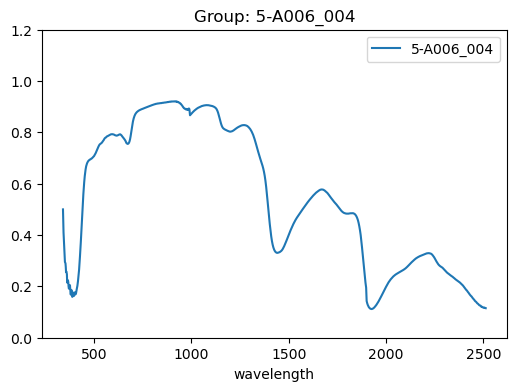

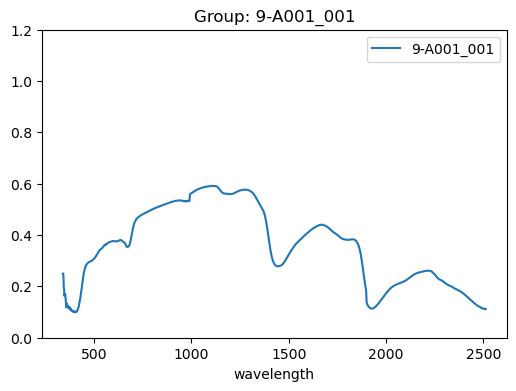

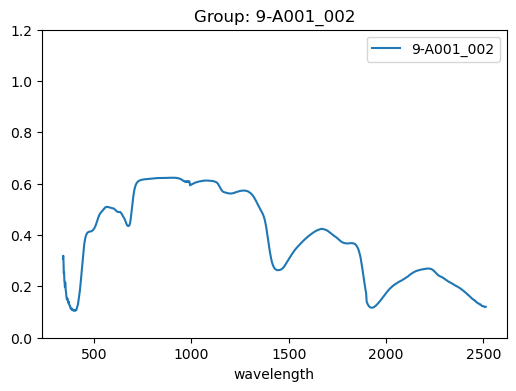

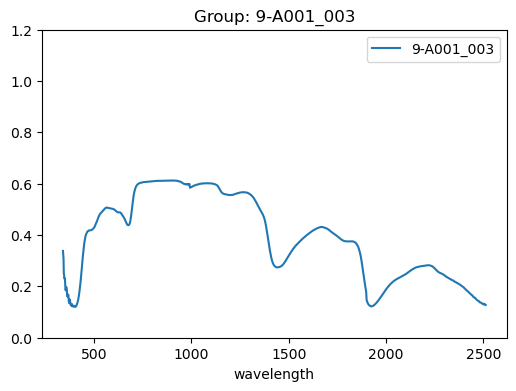

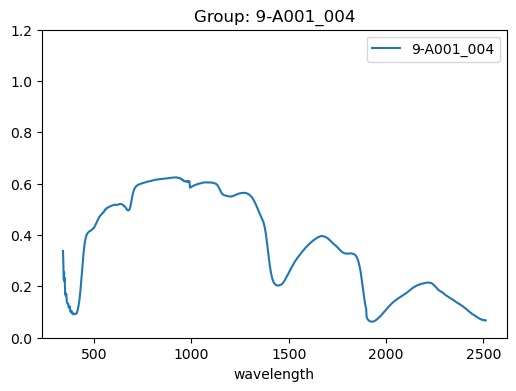

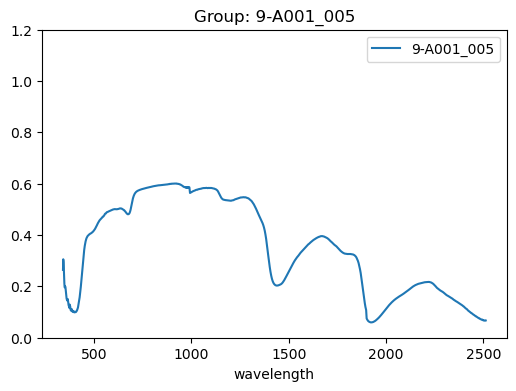

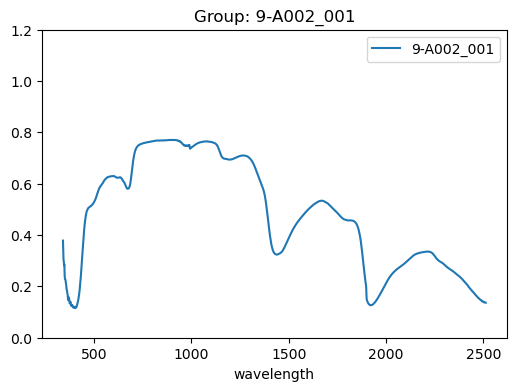

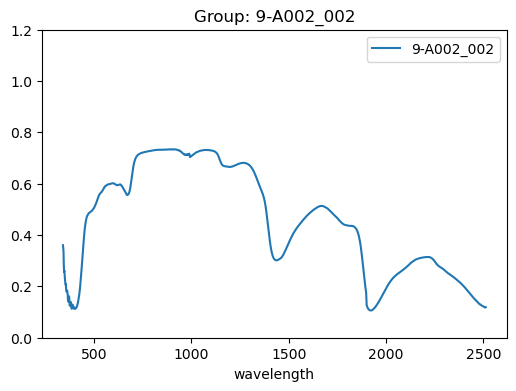

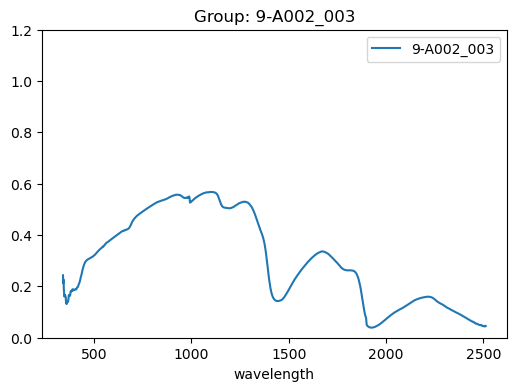

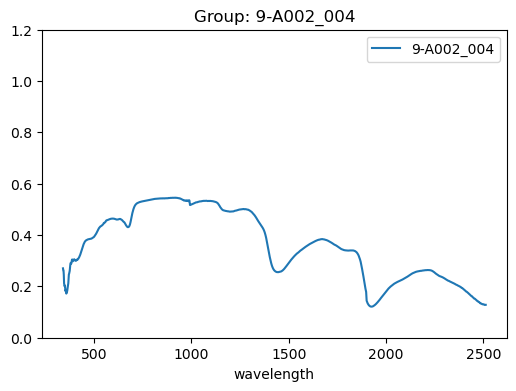

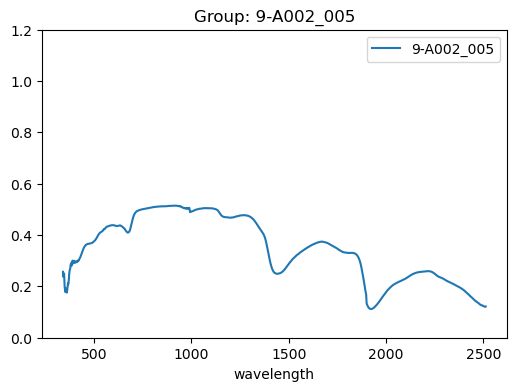

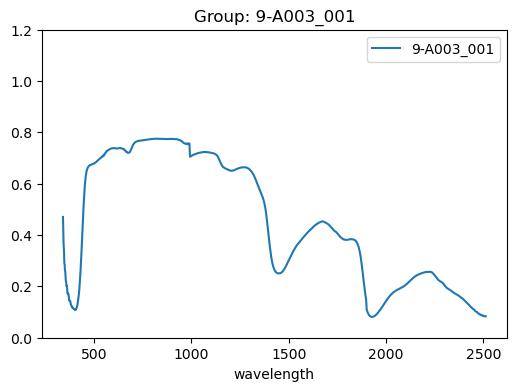

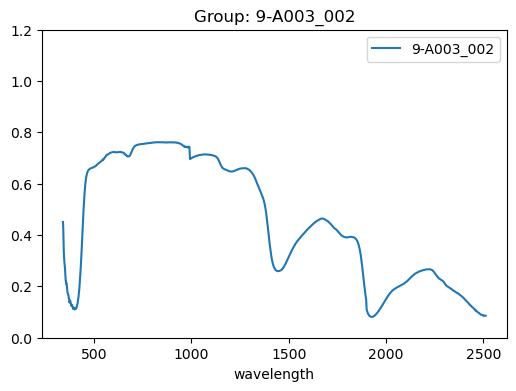

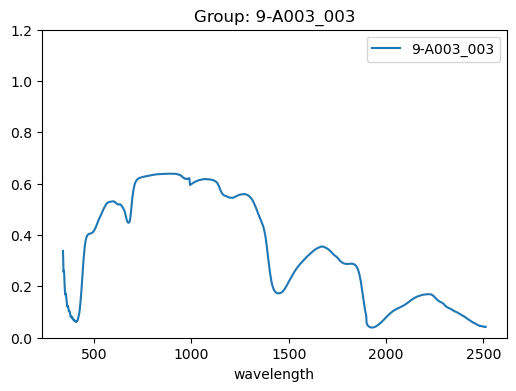

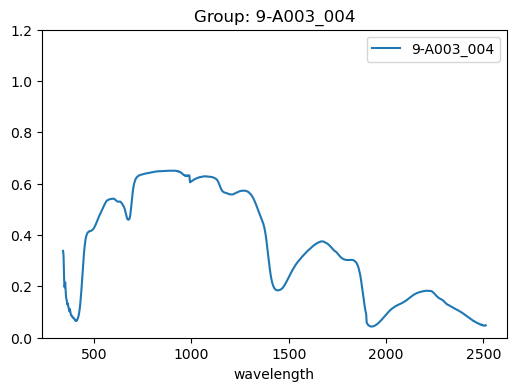

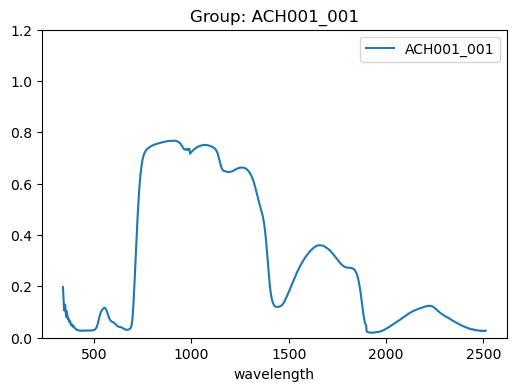

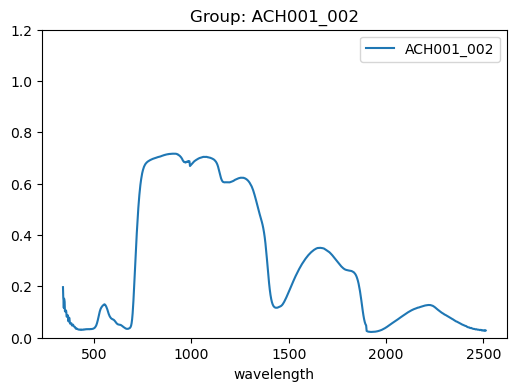

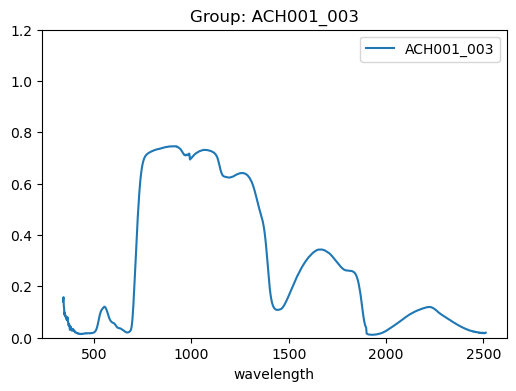

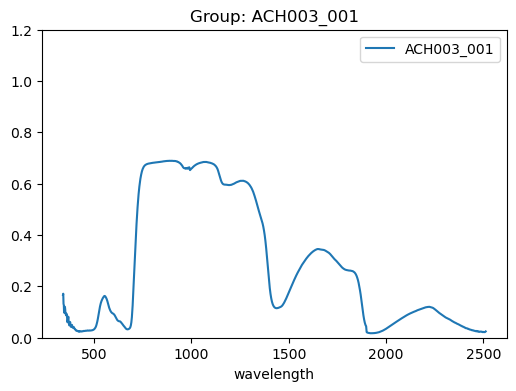

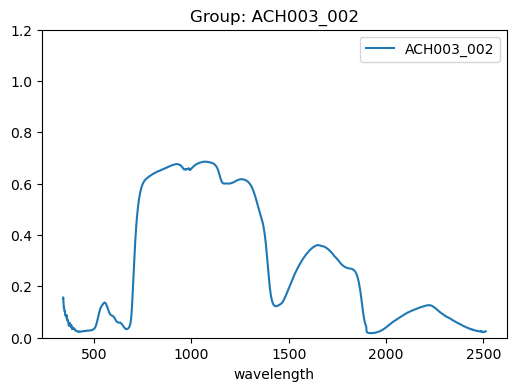

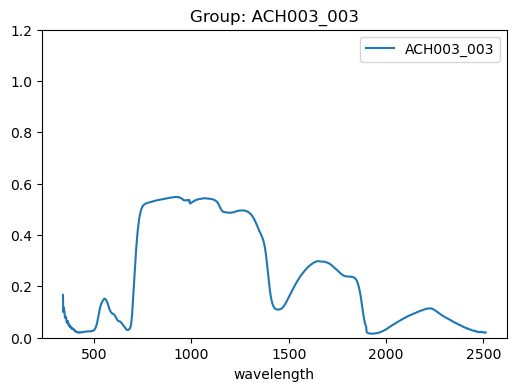

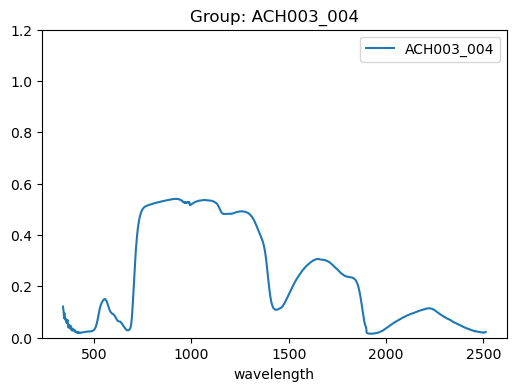

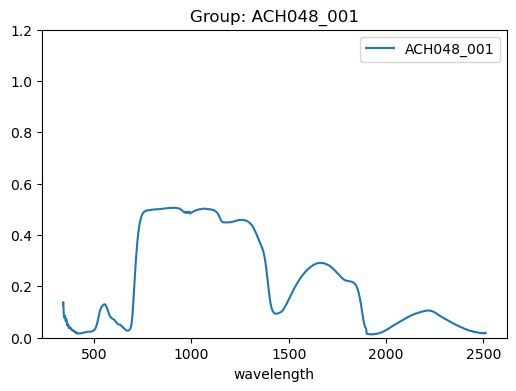

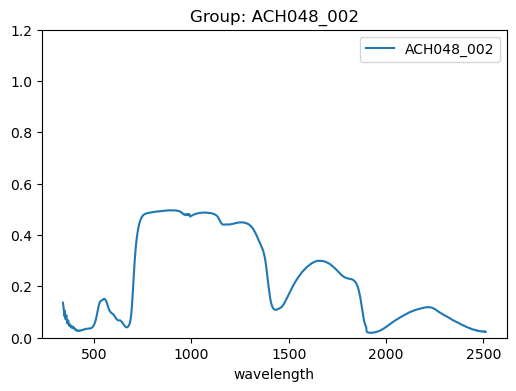

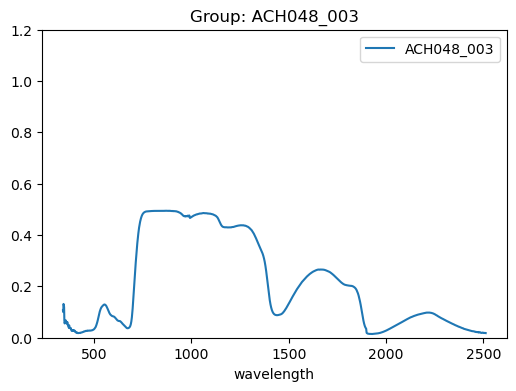

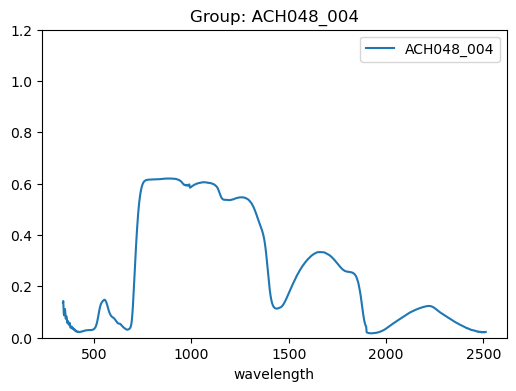

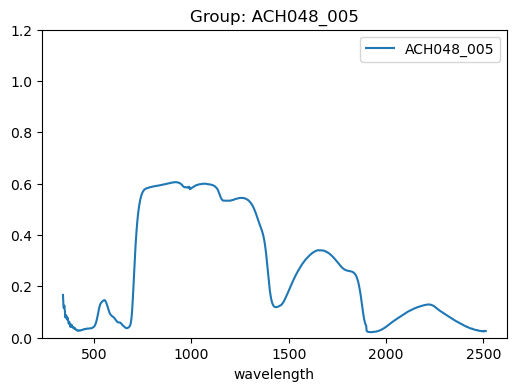

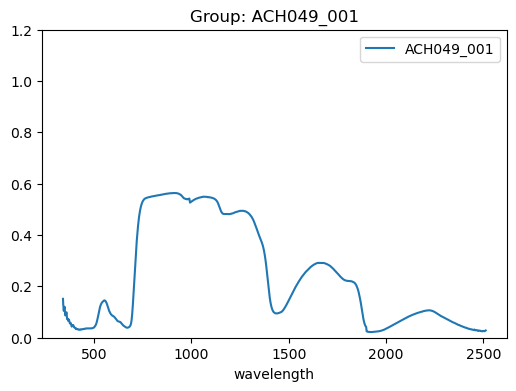

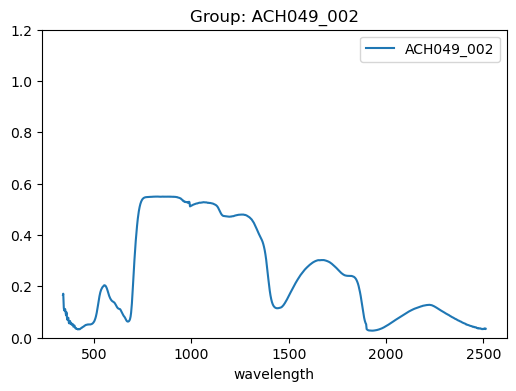

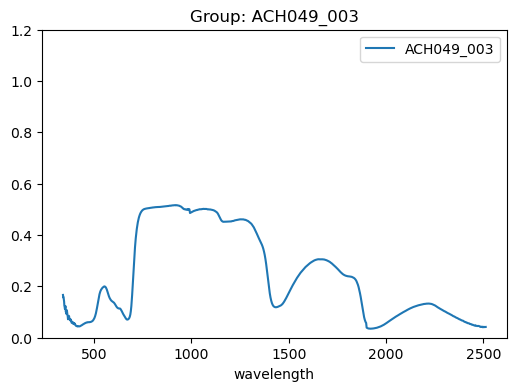

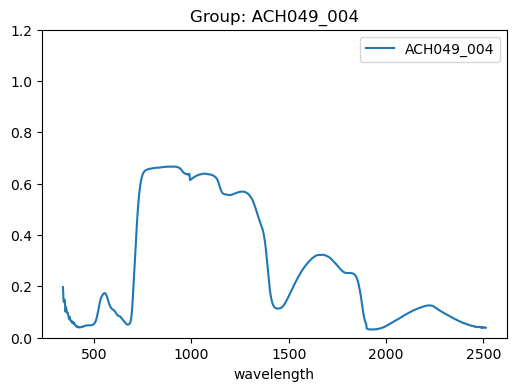

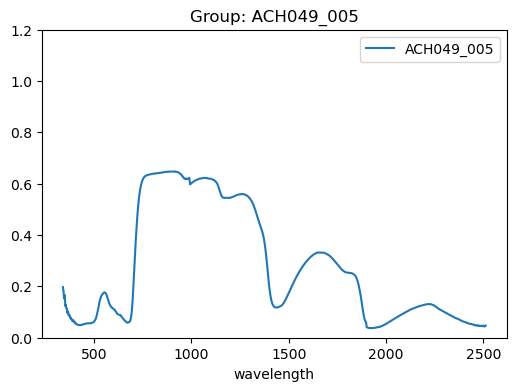

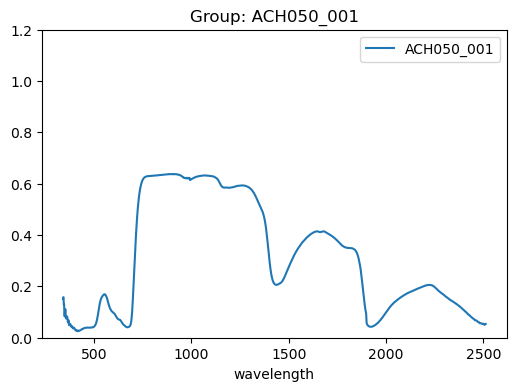

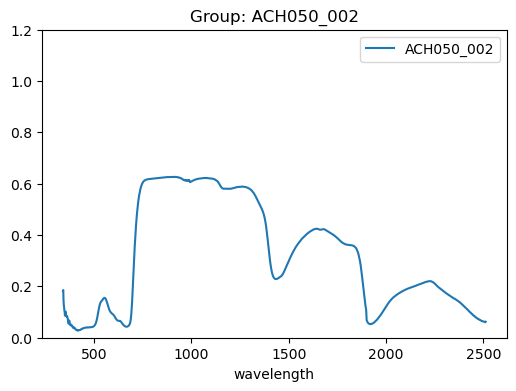

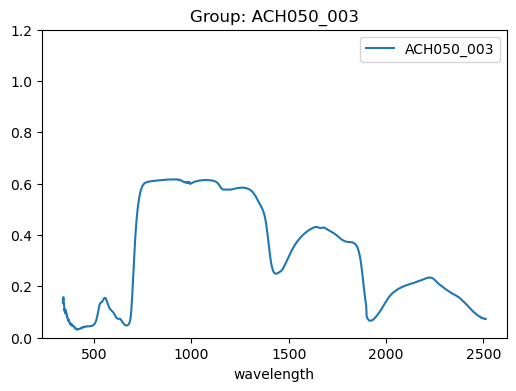

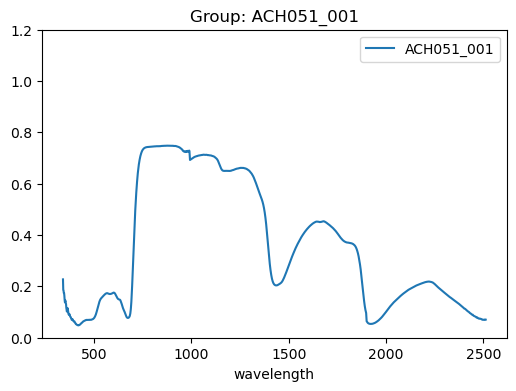

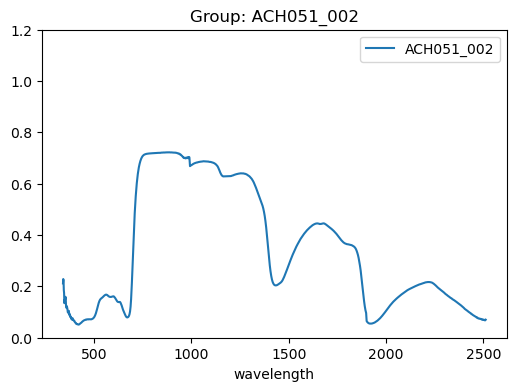

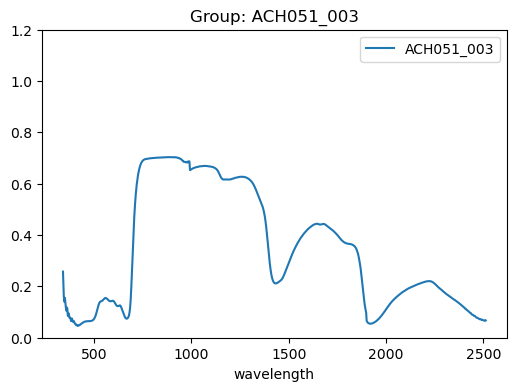

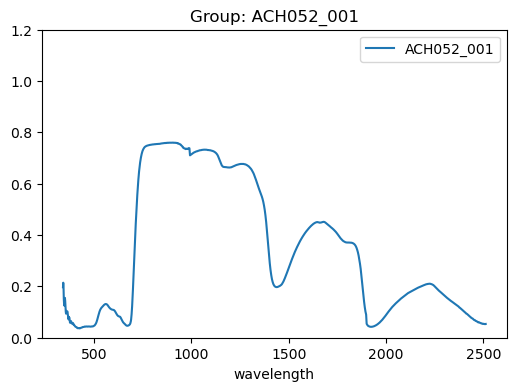

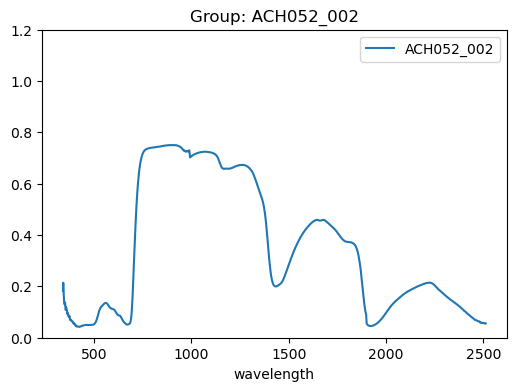

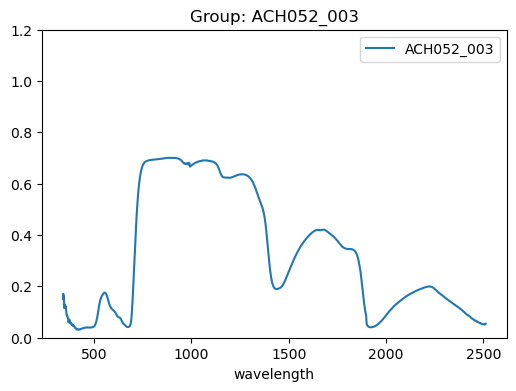

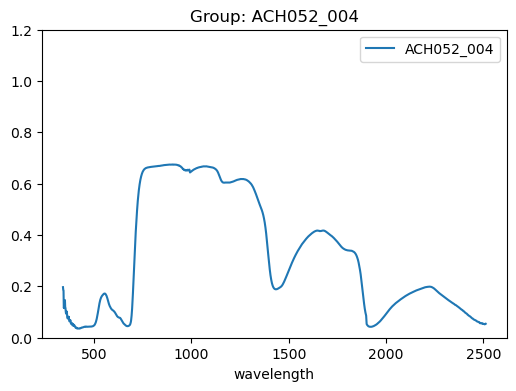

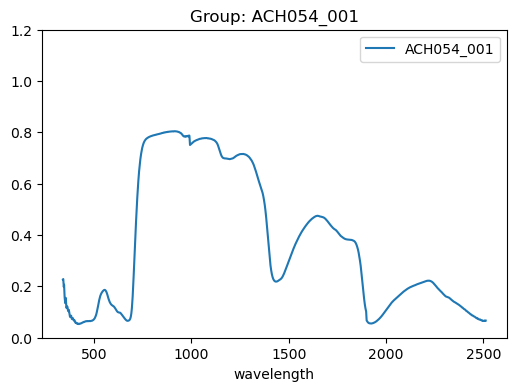

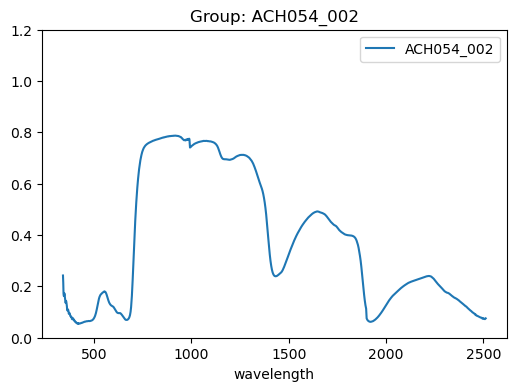

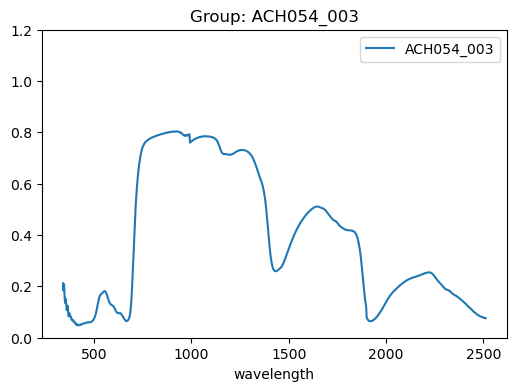

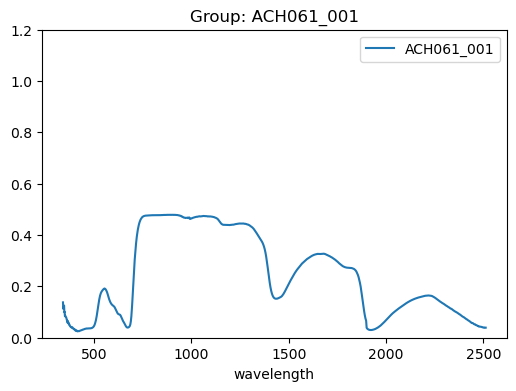

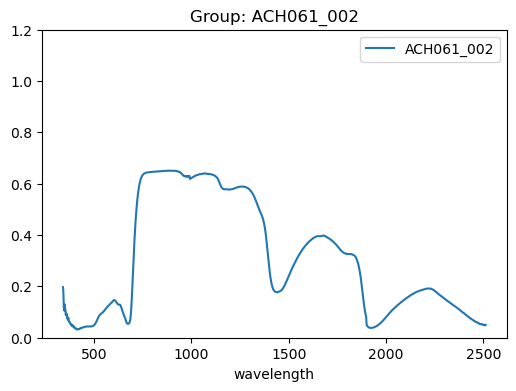

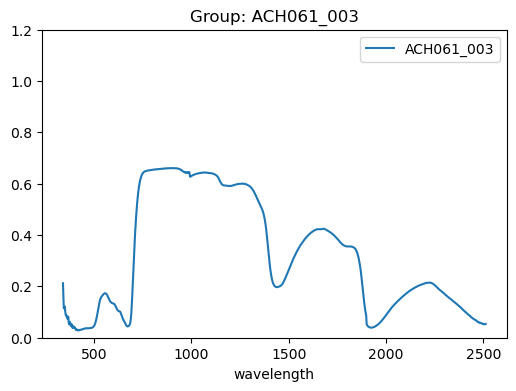

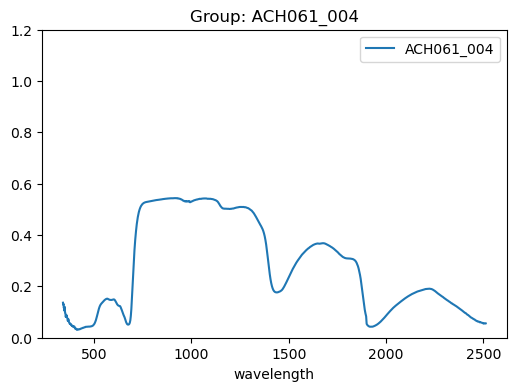

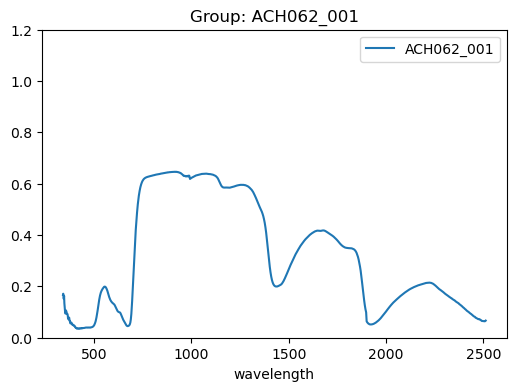

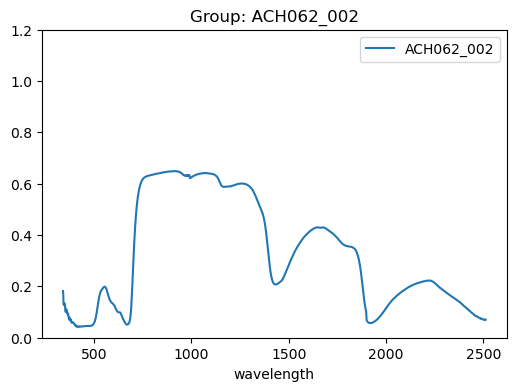

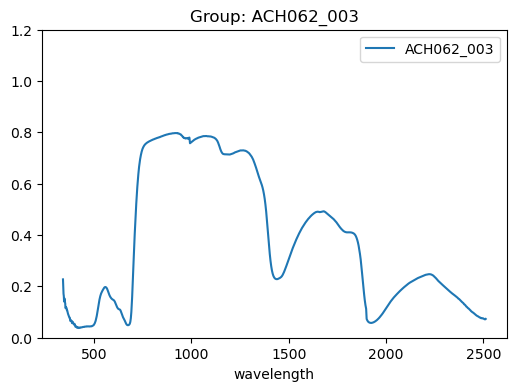

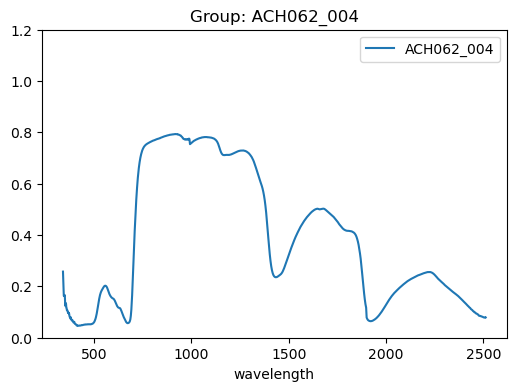

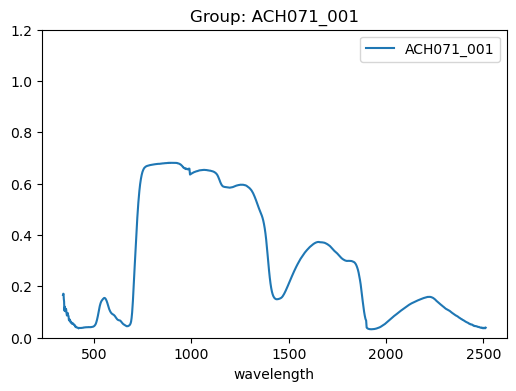

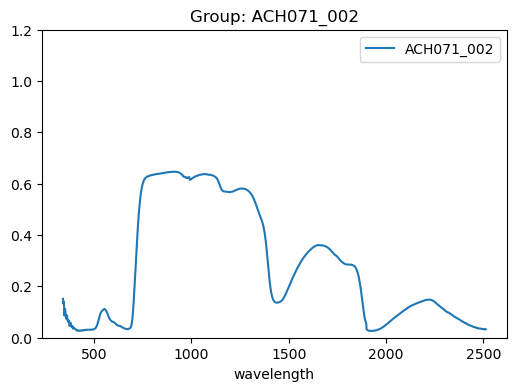

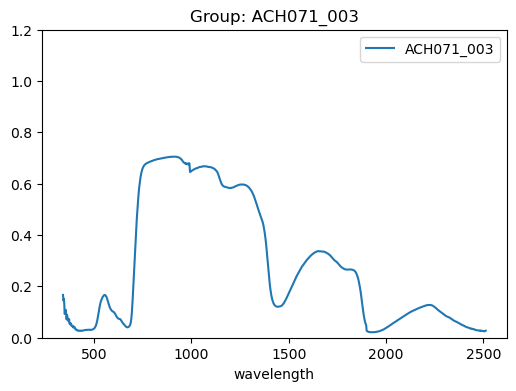

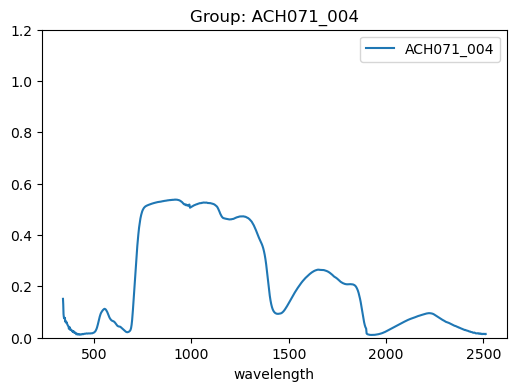

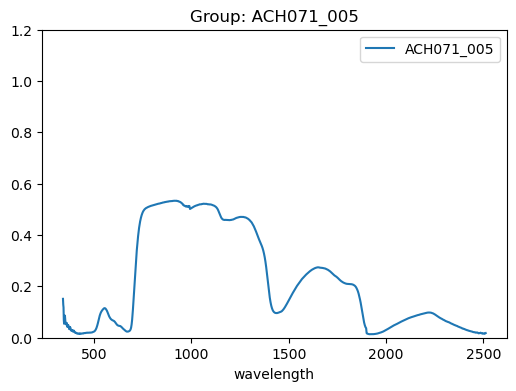

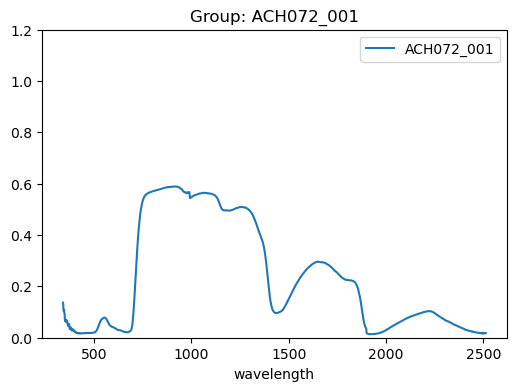

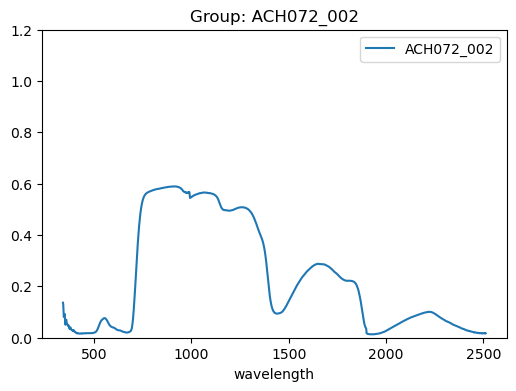

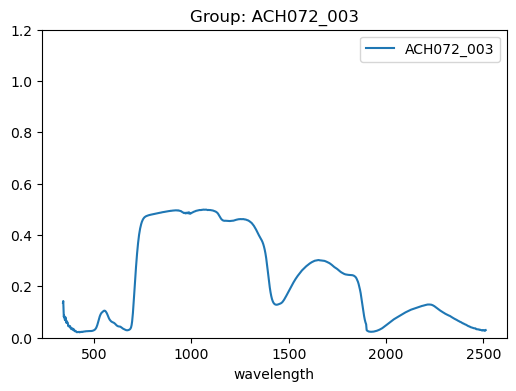

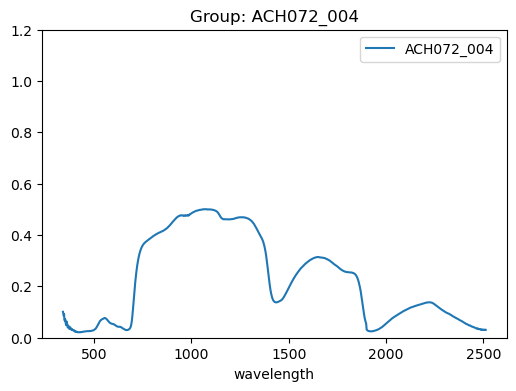

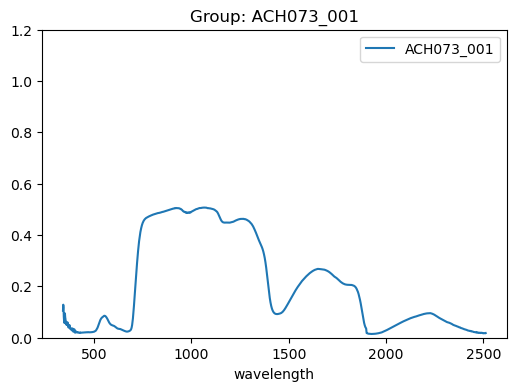

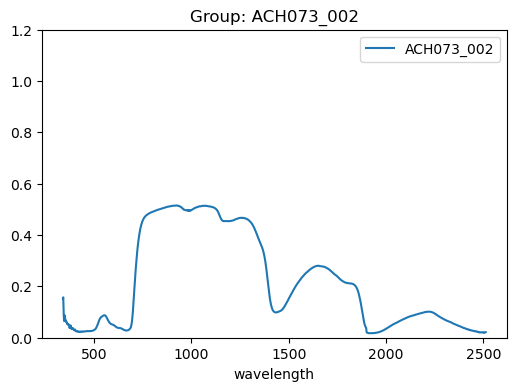

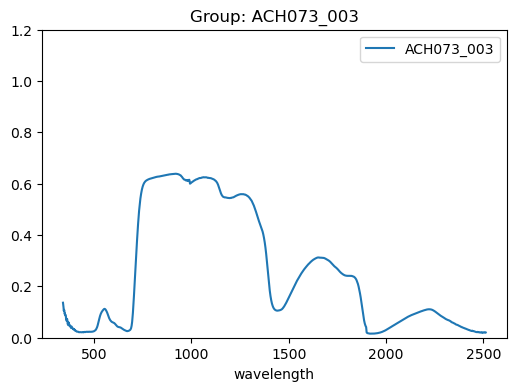

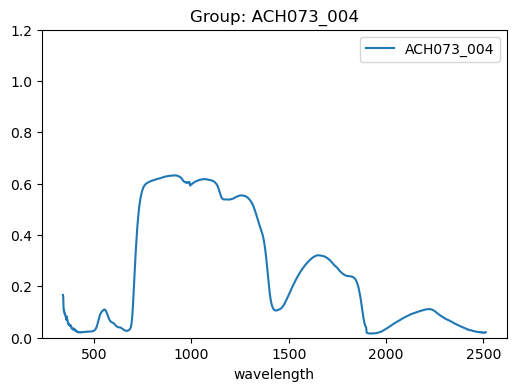

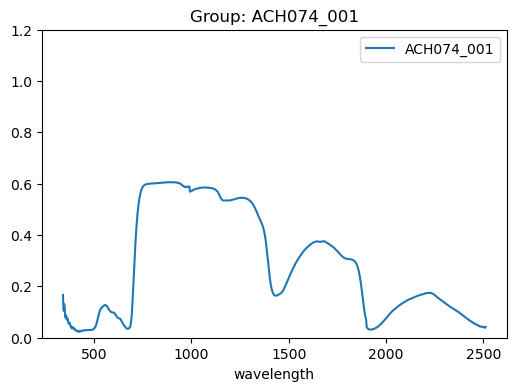

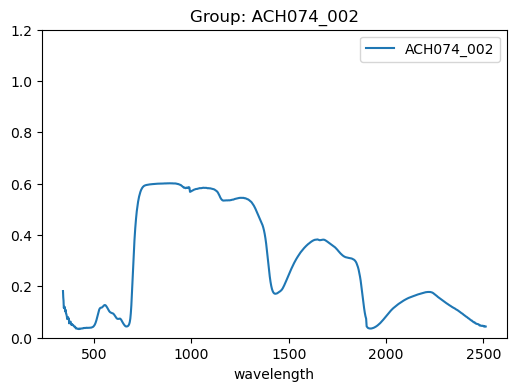

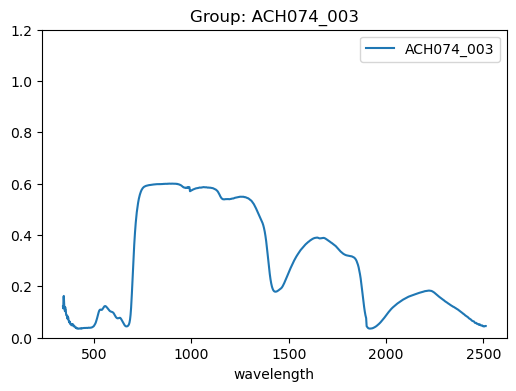

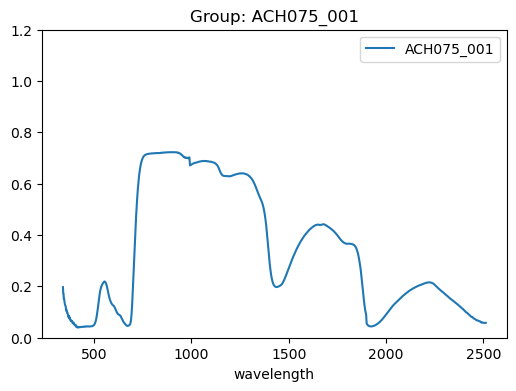

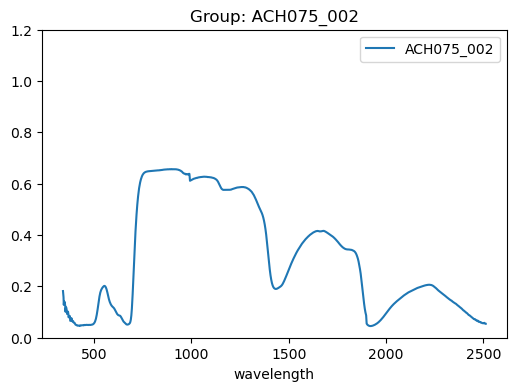

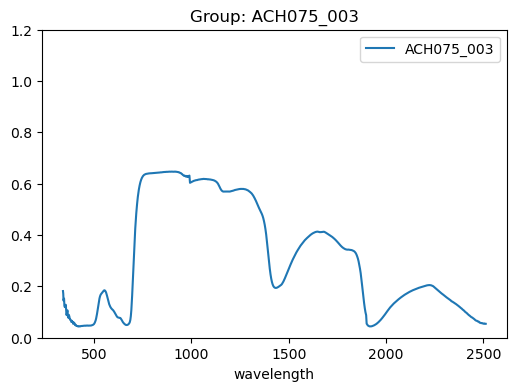

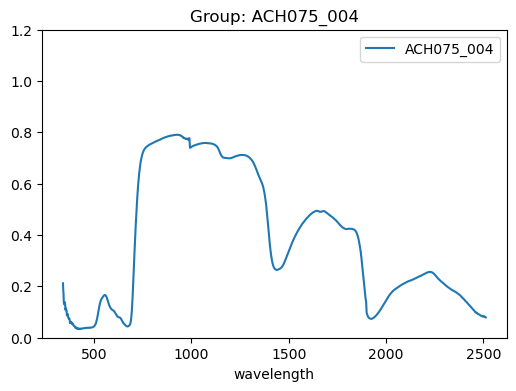

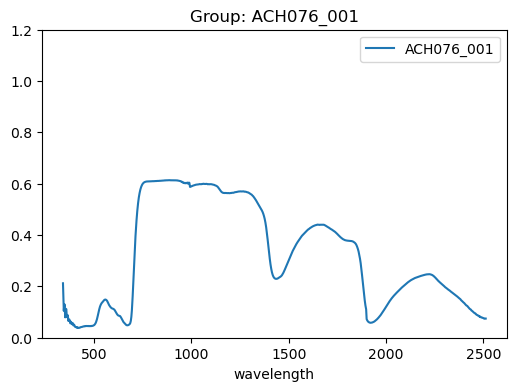

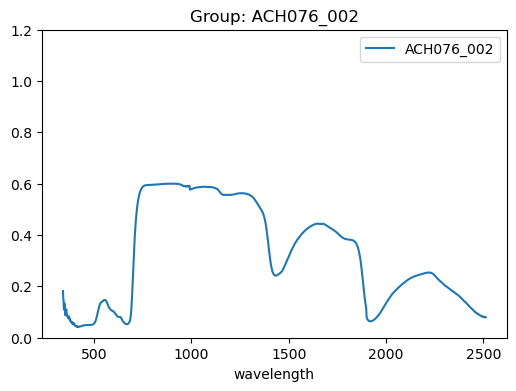

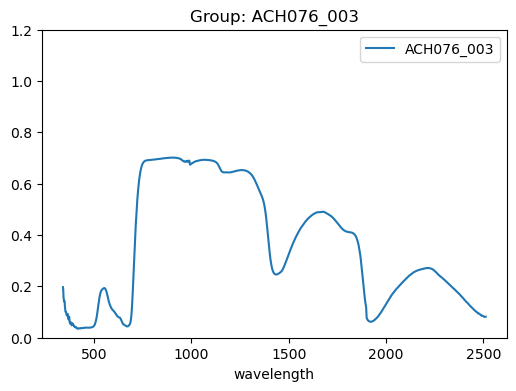

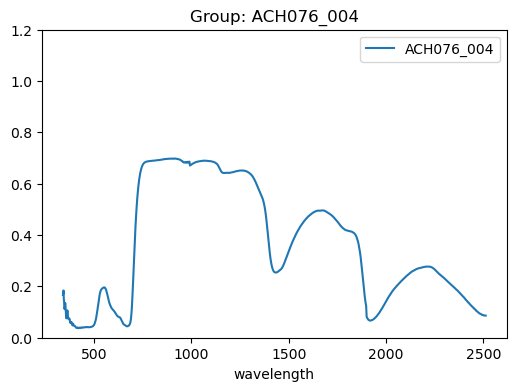

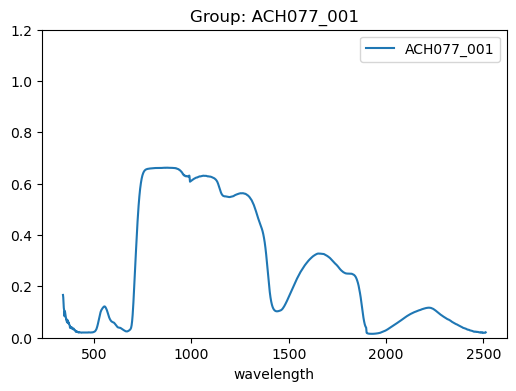

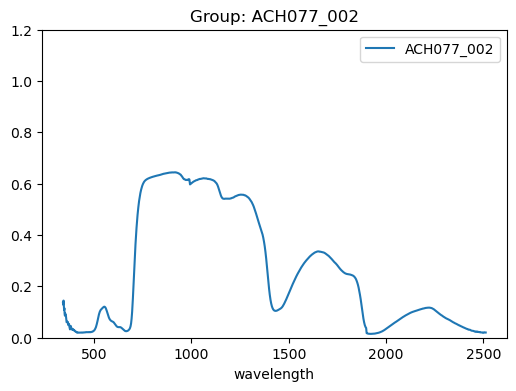

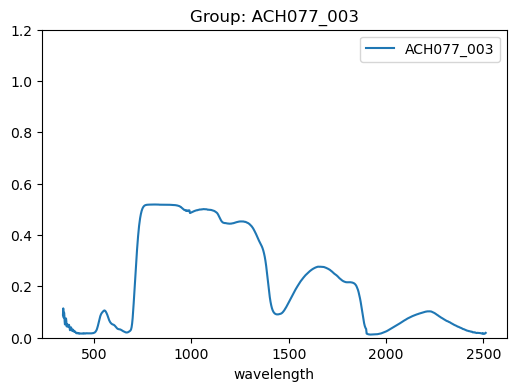

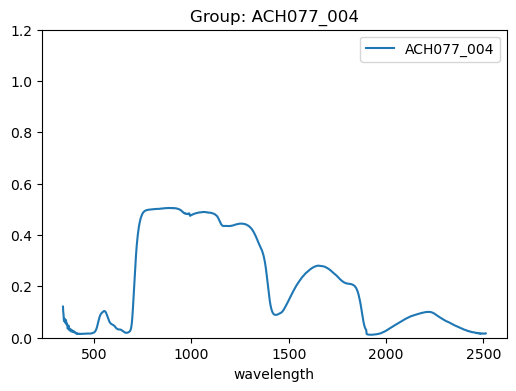

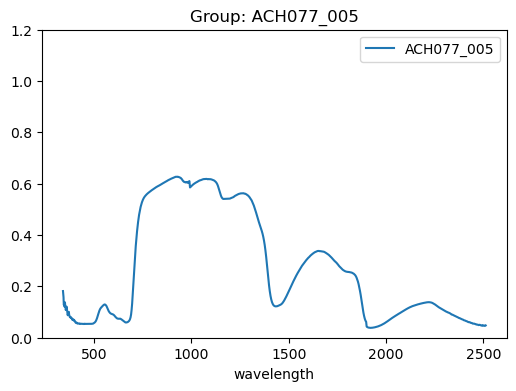

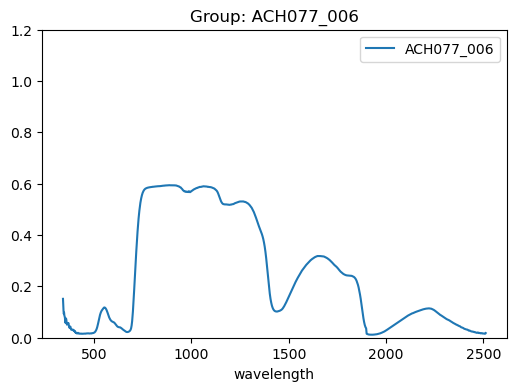

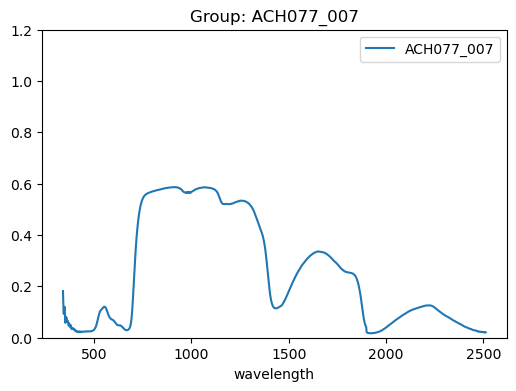

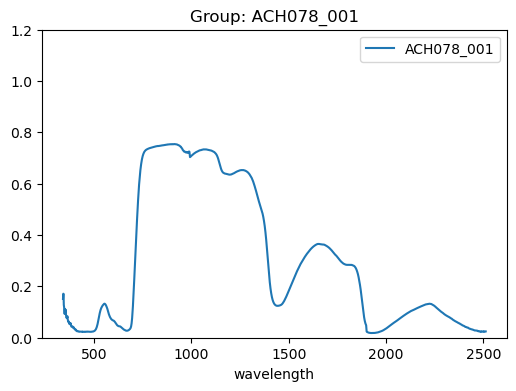

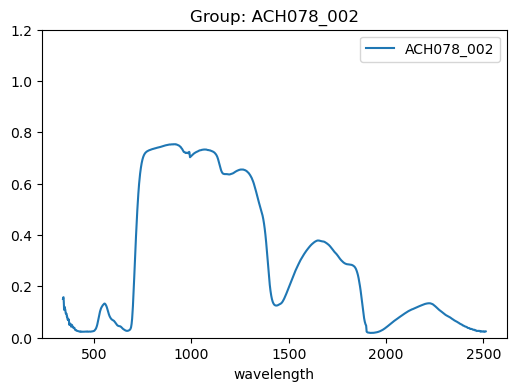

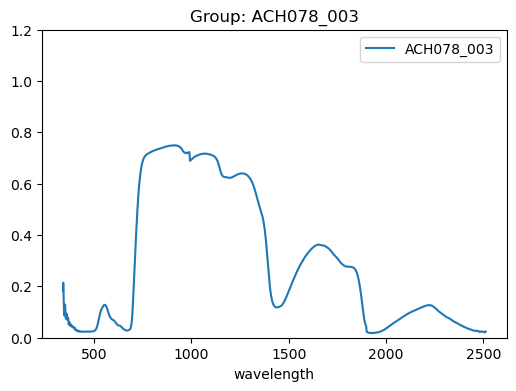

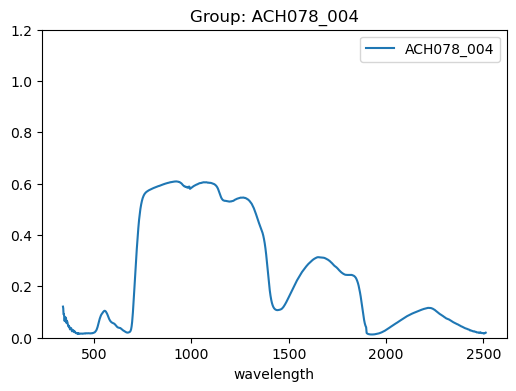

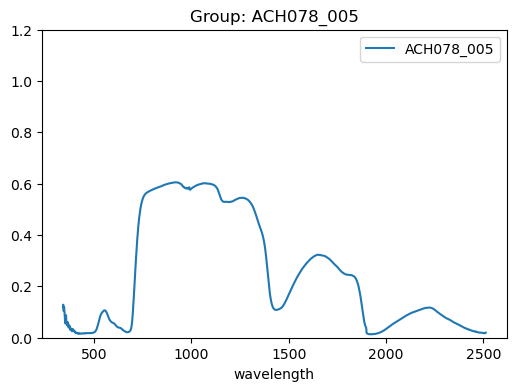

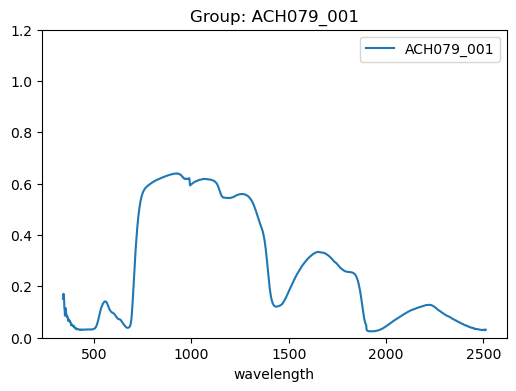

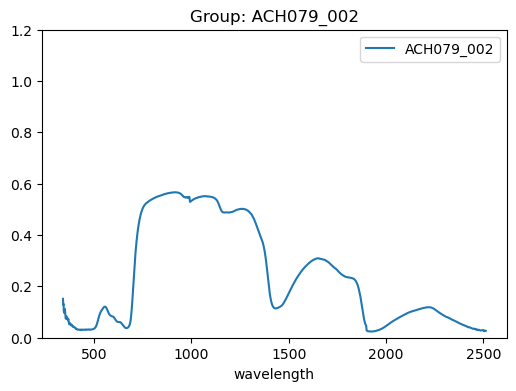

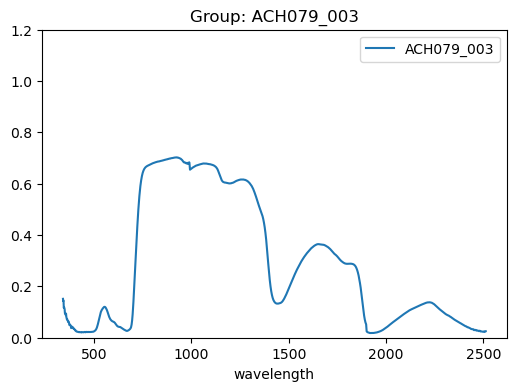

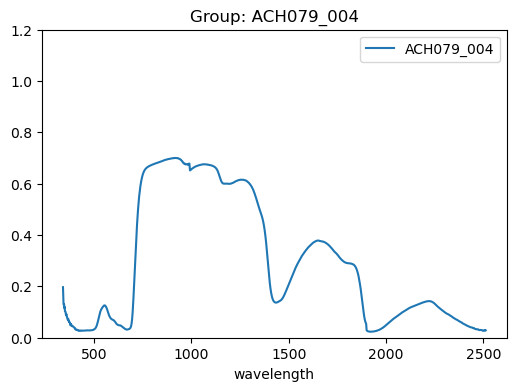

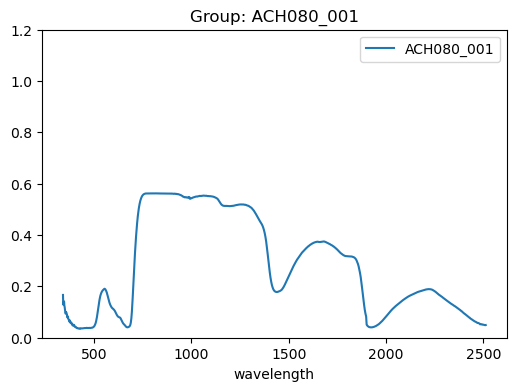

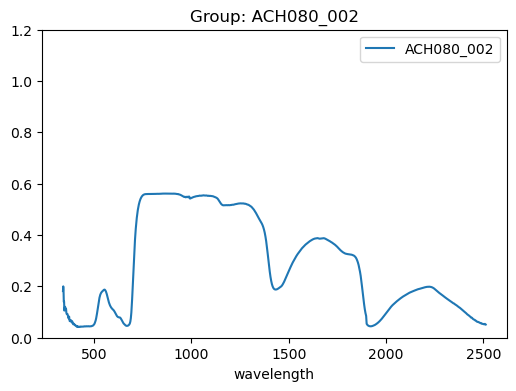

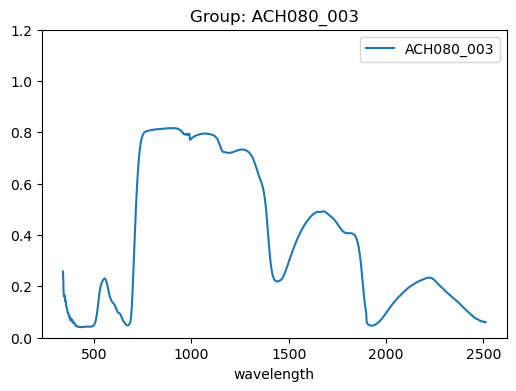

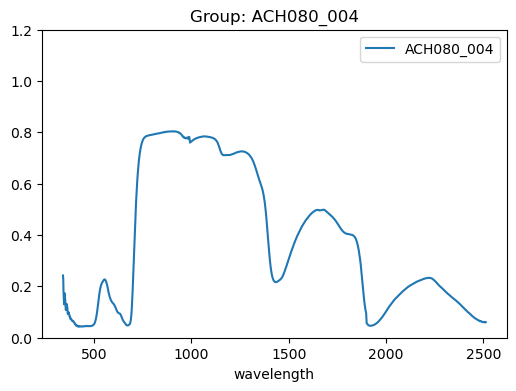

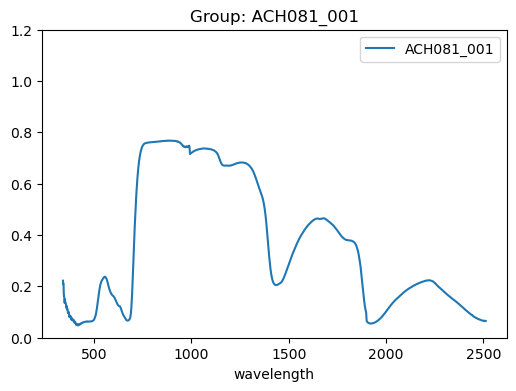

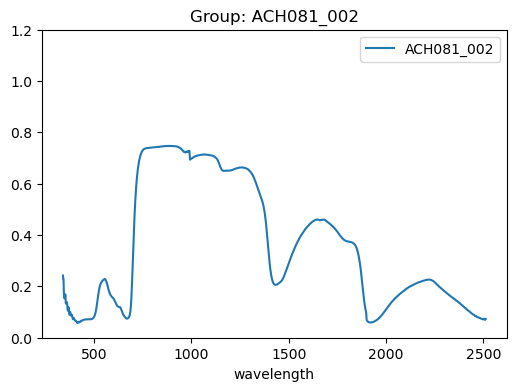

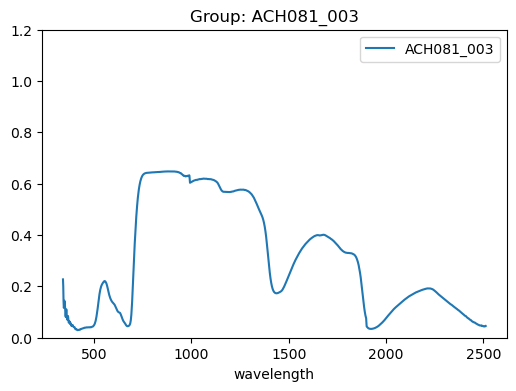

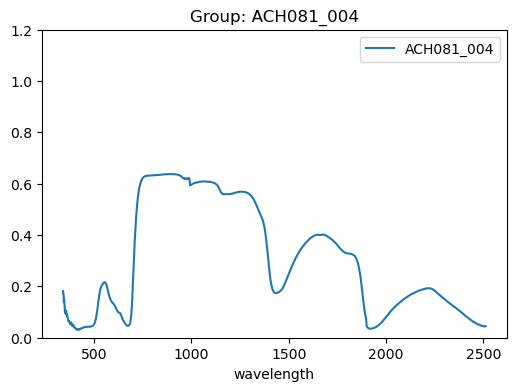

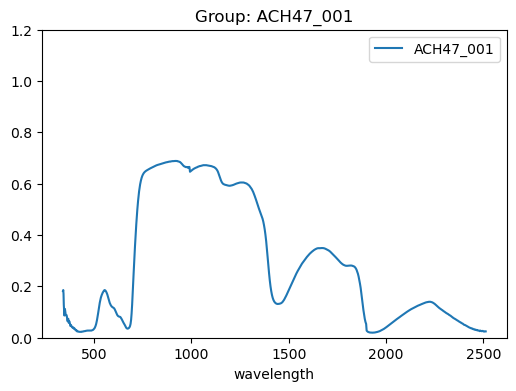

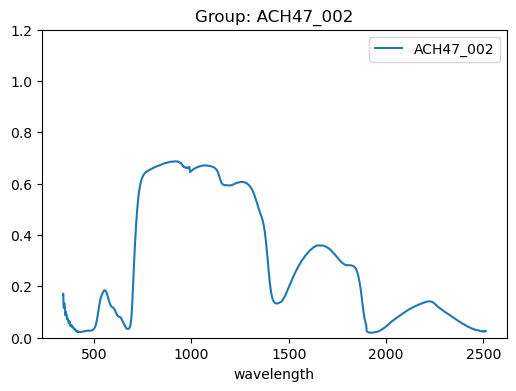

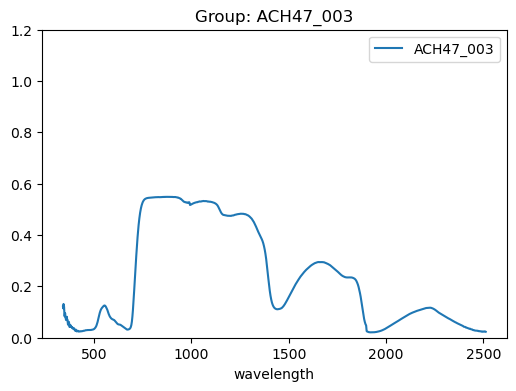

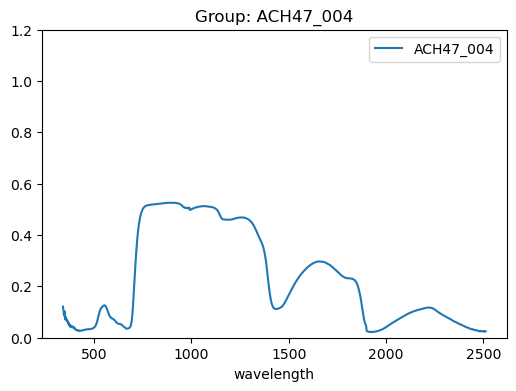

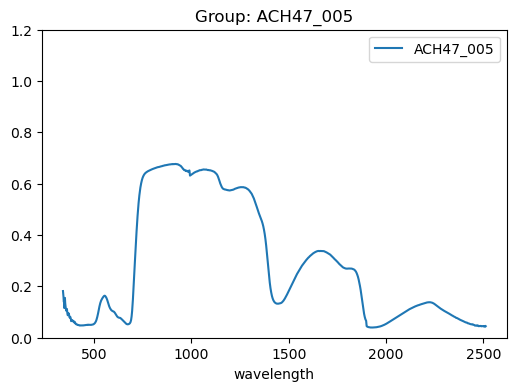

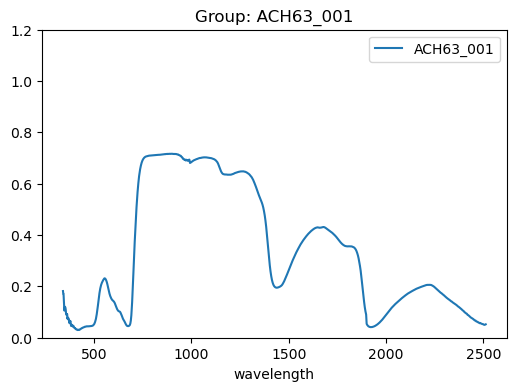

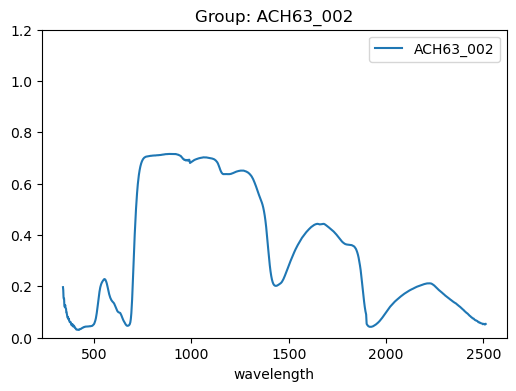

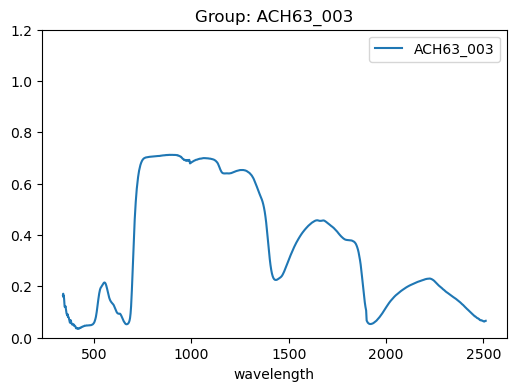

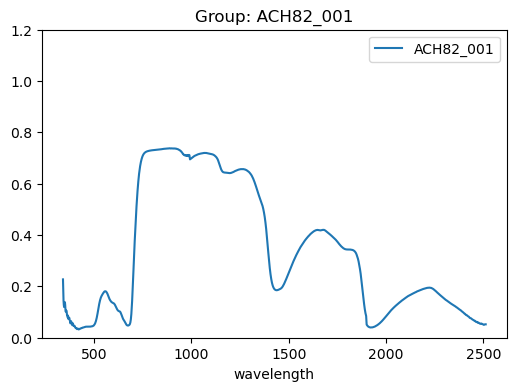

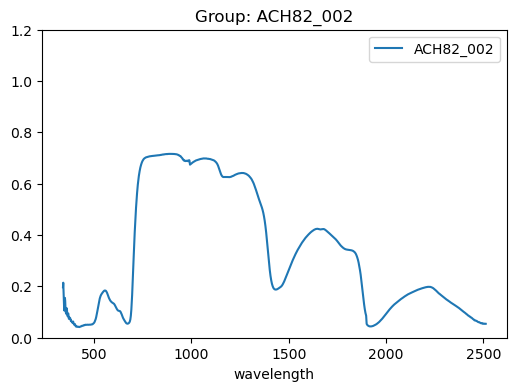

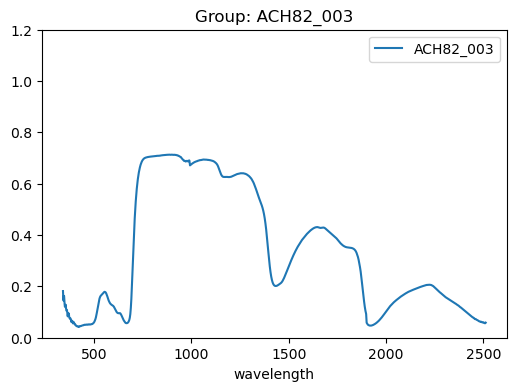

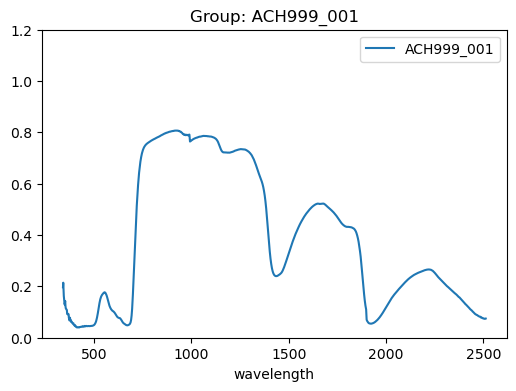

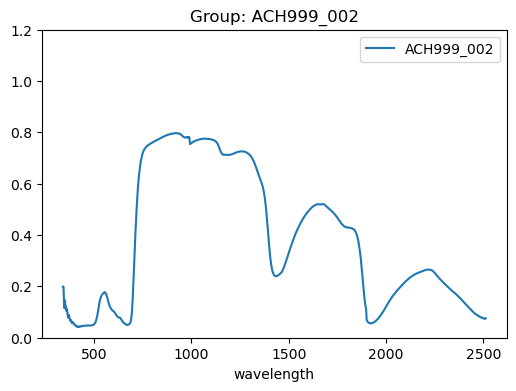

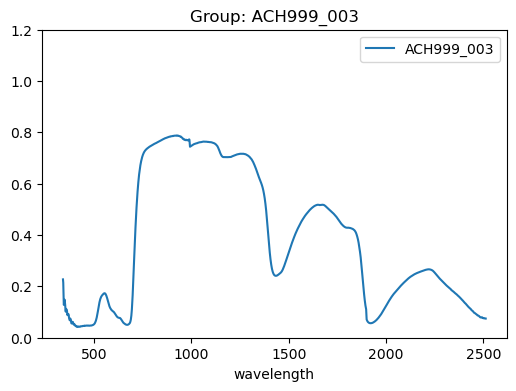

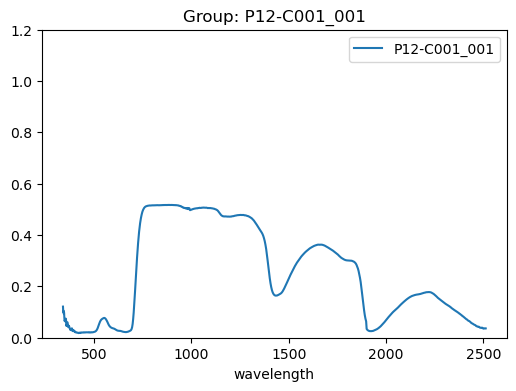

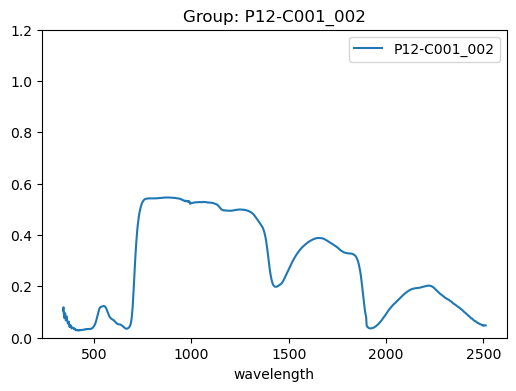

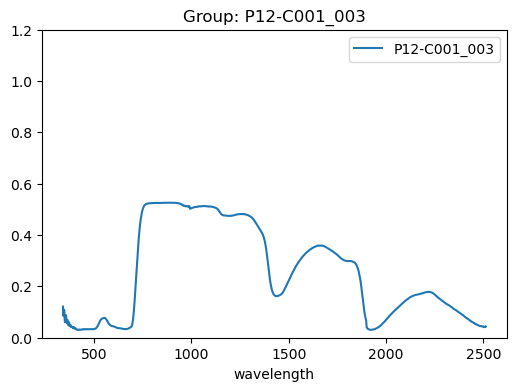

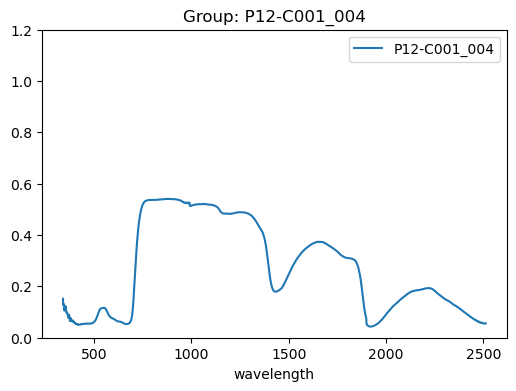

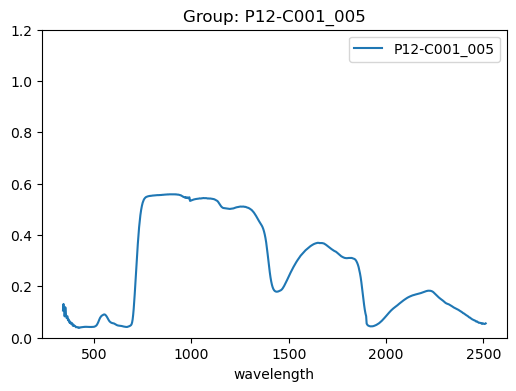

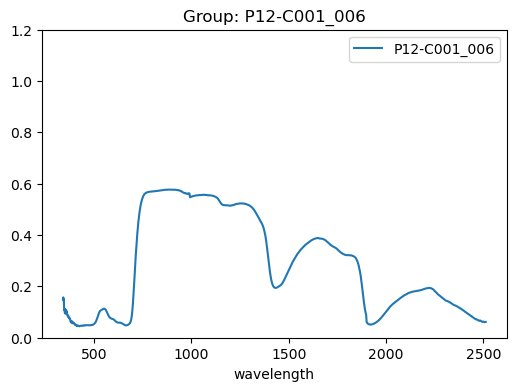

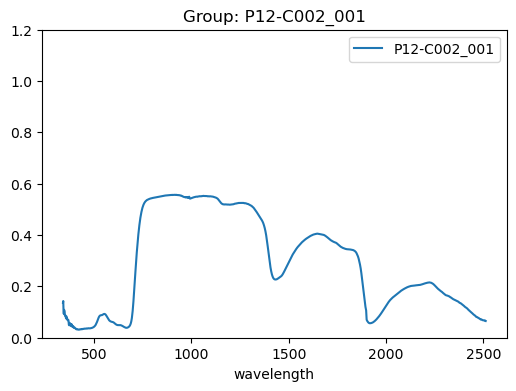

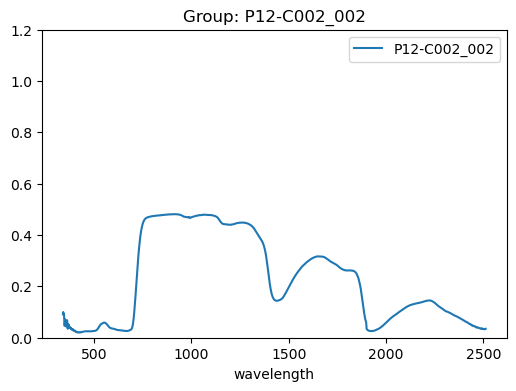

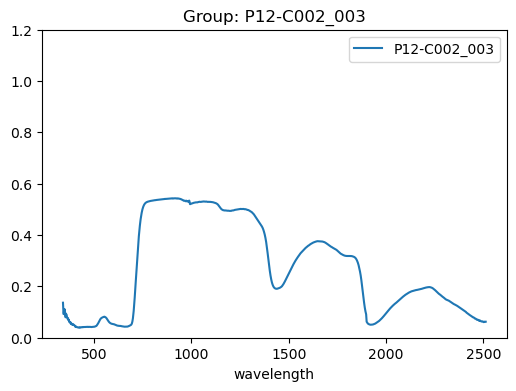

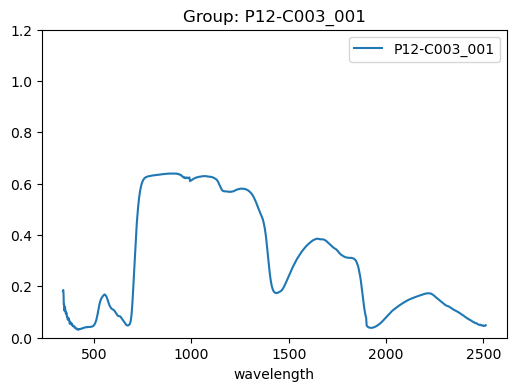

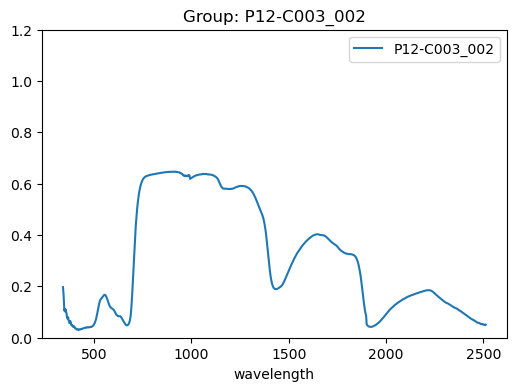

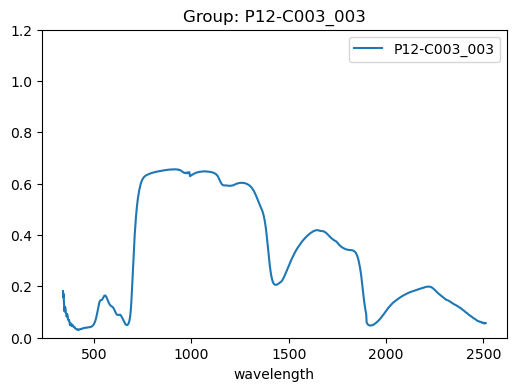

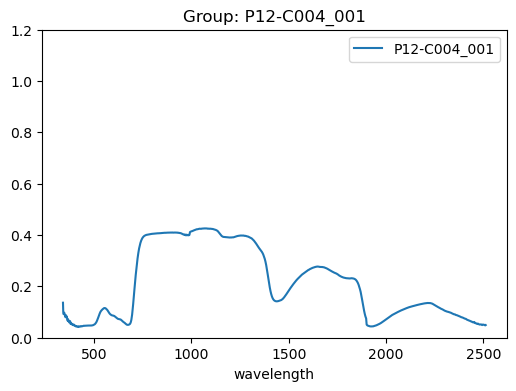

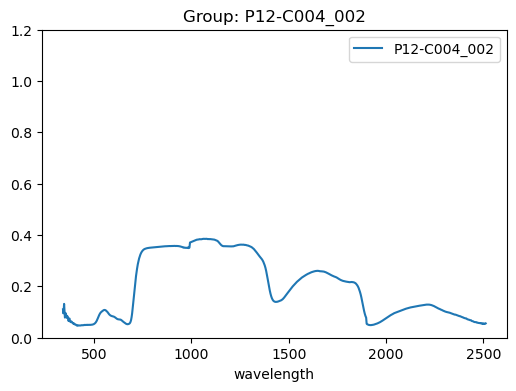

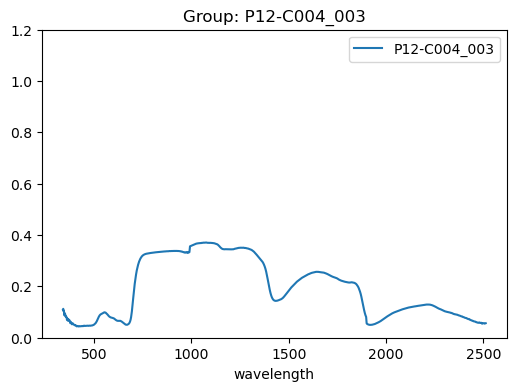

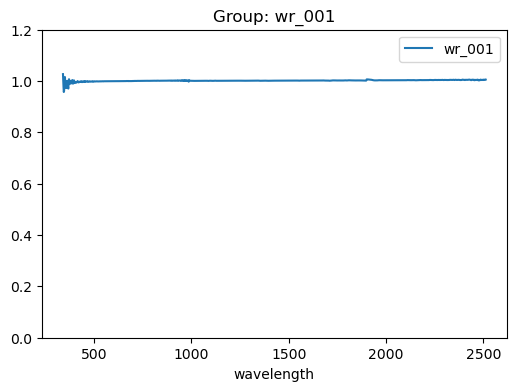

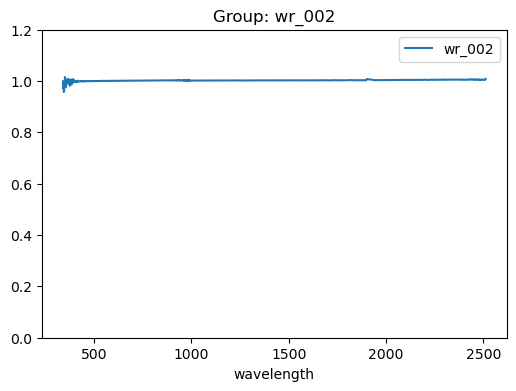

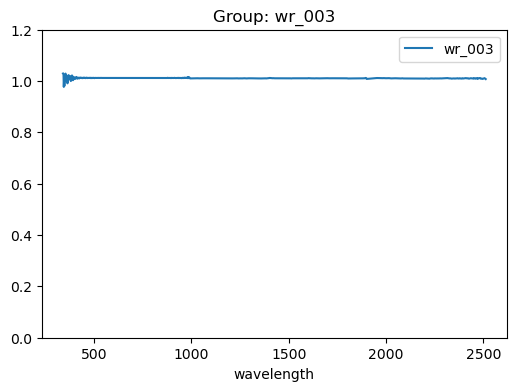

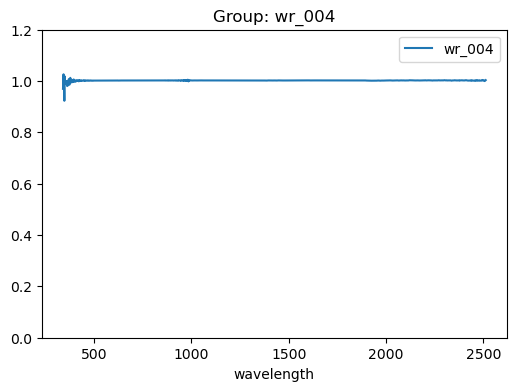

In [135]:
# Ensure group_names is a DataFrame
group_names_df = pd.DataFrame(group_names, columns=['group_name'])

# Plotting each group
import matplotlib.pyplot as plt

for spl_name in group_names_df['group_name']:
    if spl_name in groups:  # Ensure the group exists
        groups[spl_name].plot(figsize=(6, 4), ylim=(0, 1.2))
        plt.title(f"Group: {spl_name}")
        plt.show()
    else:
        print(f"Warning: Group '{spl_name}' not found in groups.")


In [136]:
# Filter spectra
from specdal.collection import df_to_collection

# If we want to remove both white and dark reflectance
c_drop = c.data[(c.data[0:] < 0.9) & (c.data.iloc[350,] > 0.05)]
c_drop = c_drop.dropna(axis=1, how="any")

# Manually drop an outlier spectrum
# List of spectral files to be excluded
from pathlib import Path
drop_file = Path(str(datadir + '/' + 'Bad_spectra.txt'))

if drop_file.is_file() == True:
    drop_fn = pd.read_csv(drop_file)
    drop_spl = list(drop_fn['Bad_file'])
    c_drop = c_drop.drop(columns = drop_spl, axis=1)
    print('List of excluded spectra:')
    print(drop_spl)


# Convert dataframe back to collection
c_tran = c_drop.transpose()
c_filter = df_to_collection(c_tran, 'WisAsp', measure_type='pct_reflect')

# Get the list of groups for the calculation of the mean
groups_filter = c_filter.groupby(separator='_', indices=[0, 1, 2])

# Plot spectra
c_filter.plot(figsize=(6, 4), legend=False, ylim=(0, 0.7))
c_filter.plot(legend=False, xlim=(900, 1100), ylim=(0.3, 0.7))
plt.show()


C:\Users\xfour\AppData\Local\Temp\ipykernel_3220\3510776594.py:5: FutureWarning: The behavior of obj[i:j] with a float-dtype index is deprecated. In a future version, this will be treated as positional instead of label-based. For label-based slicing, use obj.loc[i:j] instead
  c_drop = c.data[(c.data[0:] < 0.9) & (c.data.iloc[350,] > 0.05)]


IndexError: list index out of range

Calculate the mean spectra

In [ ]:
# plotting a single group after removing white and dark reflectance
#for spl_name in group_names.group_name:
#    groups_filter[spl_name].plot(figsize=(6, 4))
#    plt.show()

In [ ]:
# Apply jump correct
if svc_name == 'svc2040':
    tran_wave = [989.7] # 989.7 nm transition wavelength is for SVC 2040

elif svc_name == 'svc2042':
    tran_wave = [990] # 990 nm transition wavelength is for SVC 2042

# Apply jump correct
c_filter.jump_correct(splices = tran_wave, reference=0) 

c_filter.plot(legend=False, ylim=(0, 0.8))
c_filter.plot(legend=False, xlim=(900, 1100), ylim=(0.2, 0.7))
plt.show()

# Export all the processed spectra
fol_name = os.path.basename(datadir)

# Export the spectra to CSV file in the same folder
c_filter.data.to_csv(datadir + '/' + fol_name + '_Spectra_Original.csv')


In [ ]:
# Resample spectra of SVC2040 and SVC2042 to the same wavelengths
from spectral import*
import pandas as pd
from collections import OrderedDict

# Read wavelength and fwhm data from file
wvl_fwhm_ori = pd.read_csv(wave_ln)

# Get wavelength ad fwhm of the two SVCs and target wavelength
if svc_name == 'svc2040':
    wl_svc = wvl_fwhm_ori['wl_svc2040'].dropna()
    fwhm_svc = wvl_fwhm_ori['fwhm_svc2040'].dropna()

elif svc_name == 'svc2042':
    wl_svc = wvl_fwhm_ori['wl_svc2042'].dropna()
    fwhm_svc = wvl_fwhm_ori['fwhm_svc2042'].dropna()

wl_res = wvl_fwhm_ori['wl_res'].dropna()
fwhm_res = wvl_fwhm_ori['fwhm_res'].dropna()

# Resample spectra
svc_resample = BandResampler(centers1 = wl_svc, centers2 = wl_res, fwhm1 = fwhm_svc, fwhm2 = fwhm_res)
c_res = pd.DataFrame(svc_resample(c_filter.data))

c_res.columns = c_filter.data.columns
c_res.index = wl_res
c_res.index.name = 'wavelength'

# Convert dataframe back to collection
c_res_tran = c_res.transpose()
c_res_final = df_to_collection(c_res_tran, 'WisAsp', measure_type='pct_reflect')


# Plot the resample spectra
c_res_final.plot(legend=False, ylim=(0, 0.8))
c_res_final.plot(legend=False, xlim=(900, 1100), ylim=(0.2, 0.7))
plt.show()

In [ ]:
# Export all the processed spectra
fol_name = os.path.basename(datadir)

# Export the spectra to CSV file in the same folder
c_res_final.data.to_csv(datadir + '/' + fol_name + '_Spectra_Resampled.csv')


In [ ]:
# Calculate the group means
# Get the list of groups for the calculation of the mean
groups_filter = c_res_final.groupby(separator='_', indices=[0, 1, 2])

# Calculate the group means
group_means = sd.Collection(name='Group Means')
for group_key, group_collection in groups_filter.items():
    group_means.append(group_collection.mean())

# plot the group means
group_means.plot(legend=False, title='Group means', figsize=(11, 7), xlim=(300,2550), ylim=(0, 0.8), cmap="jet")
plt.xlabel('Wavelength (nm)', fontsize=15)
plt.ylabel('Reflectance', fontsize=15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(bbox_to_anchor=(1.86, 1), loc='upper right', ncol=2, fontsize=13)
plt.show()

In [ ]:
# Calculate group standard deviation
group_std = sd.Collection(name='std')

for group_key, group_collection in groups_filter.items():
    group_std.append(group_collection.std())

# plot the group std
group_std.plot(legend=False, title='Group standard deviation', figsize=(11, 7), xlim=(300,2550), ylim=(0, 0.1), cmap="jet")
plt.xlabel('Wavelength (nm)', fontsize=15)
plt.ylabel('Standard deviation', fontsize=15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(bbox_to_anchor=(1.86, 1), loc='upper right', ncol=2, fontsize=13)
plt.show()

In [ ]:
# Export the final mean and std of spectra to CSV
# get the base name of the immediate folder
fol_name = os.path.basename(datadir)

# Export the mean spectra to CSV file in the same folder
group_means.data.to_csv(datadir + '/' + fol_name + '_Spectra_Mean.csv')

# Export the std spectra to CSV file in the same folder
group_std.data.to_csv(datadir + '/' + fol_name + '_Spectra_Std.csv')

In [138]:
!where python

C:\Users\xfour\anaconda4\envs\SPEC\python.exe
C:\Users\xfour\anaconda3\python.exe
C:\Users\xfour\AppData\Local\Microsoft\WindowsApps\python.exe
